# Librerias

In [3]:
# conda install -n calib_fed1_env -c conda-forge xlrd matplotlib seaborn imbalanced-learn shap -y
# pip install optbinning

In [7]:
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score, recall_score, precision_score,
    accuracy_score, classification_report, confusion_matrix, roc_curve
)

from imblearn.over_sampling import SMOTE
from optbinning import OptimalBinning

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight

import shap
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evitar saltos en la representación
pd.set_option('display.max_colwidth', None) # Mostrar todo el contenido de las celdas (columnas), sin truncar texto largo

# Funciones

In [8]:
def analizar_variable_categorica(df, columna, target='default payment next month'):
    """
    Función para analizar una variable categórica:
    - Cuenta el número de observaciones por categoría.
    - Calcula la probabilidad de impago (tasa de default) por categoría.
    
    Parámetros:
    - df: DataFrame de entrada.
    - columna: str, nombre de la columna categórica a analizar.
    - target: str, nombre de la variable objetivo (por defecto 'default payment next month').
    
    Retorna:
    - DataFrame resumen (n_clientes y tasa_default por categoría).
    """
    
    print(f'\nAnálisis de {columna}:')

    resumen = df.groupby(columna, observed=True).agg(
        n_clientes=(target, 'count'),
        tasa_default=(target, 'mean')
    ).sort_index()
    
    print(resumen)
    print('-' * 50)
    
    return resumen

In [9]:
def graficar_distribucion_default(df, columna, target='default payment next month', bins=30):
    """
    Función para graficar:
    - (1) Histograma + curva de tasa de default
    - (2) Boxplot
    Todo en un único figure con dos subplots lado a lado.
    
    Parámetros:
    - df: DataFrame original
    - columna: str, columna a analizar
    - target: str, columna de default (por defecto 'default payment next month')
    - bins: int, número de bins para el histograma (default 30)
    """
    # Crear copia para no tocar df original
    df_temp = df.copy()

    # Definir bins
    bin_edges = np.linspace(df_temp[columna].min(), df_temp[columna].max(), bins)
    df_temp['bin_temp'] = pd.cut(df_temp[columna], bins=bin_edges)

    # Agrupar para calcular tasa de default
    bin_stats = df_temp.groupby('bin_temp').agg(
        n_clientes=(target, 'count'),
        tasa_default=(target, 'mean')
    ).reset_index()

    bin_stats['bin_center'] = [interval.mid for interval in bin_stats['bin_temp']]

    # --- Crear figure global ---
    plt.figure(figsize=(14, 5))

    # --- Subplot 1: Histograma + curva de default ---
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(df_temp[columna], bins=bin_edges, color='skyblue', alpha=0.6, ax=ax1, kde=True)
    ax1.set_xlabel(columna)
    ax1.set_ylabel('Número de clientes', color='blue')

    # Segundo eje para curva
    ax2 = ax1.twinx()
    ax2.plot(bin_stats['bin_center'], bin_stats['tasa_default'], color='red', marker='o')
    ax2.set_ylabel('Probabilidad de default', color='red')
    ax2.set_ylim(0, 1)

    ax1.set_title(f'Histograma y Curva de Default para {columna}')

    # --- Subplot 2: Boxplot ---
    ax3 = plt.subplot(1, 2, 2)
    sns.boxplot(x=df_temp[columna], ax=ax3)
    ax3.set_xlabel(columna)
    ax3.set_title(f'Boxplot de {columna}')

    plt.tight_layout()
    plt.show()

In [10]:
def analizar_outliers_IQR(df, columnas):
    quantiles = df[columnas].quantile([0.25, 0.75])
    Q1 = quantiles.loc[0.25]
    Q3 = quantiles.loc[0.75]
    IQR = Q3 - Q1
    lower_bounds = Q1 - 1.5 * IQR
    upper_bounds = Q3 + 1.5 * IQR

    resumen = []
    columnas_acotadas = {}

    for col in columnas:
        lower = lower_bounds[col]
        upper = upper_bounds[col]

        is_outlier = (df[col] < lower) | (df[col] > upper)
        outliers_count = is_outlier.sum()

        columnas_acotadas[f"{col}_acot1"] = df[col].clip(lower, upper)

        resumen.append({
            'Variable': col,
            'Total Registros': len(df),
            'Porcentaje IQR (%)': (outliers_count / len(df)) * 100,
            'MAX Original': df[col].max(),
            'MIN Original': df[col].min(),
            'MAX después de Acotar IQR': df[col].clip(lower, upper).max(),
            'MIN después de Acotar IQR': df[col].clip(lower, upper).min()
        })

    acotadas_df = pd.DataFrame(columnas_acotadas)
    df_resultado = pd.concat([df, acotadas_df], axis=1)
    resumen_df = pd.DataFrame(resumen).sort_values(by="Porcentaje IQR (%)", ascending=False)

    return df_resultado, resumen_df

In [11]:
def analizar_outliers_percentil(df, columnas, p_inf=0.01, p_sup=0.99):
    lower_bounds = df[columnas].quantile(p_inf)
    upper_bounds = df[columnas].quantile(p_sup)

    resumen = []
    columnas_acotadas = {}

    for col in columnas:
        lower = lower_bounds[col]
        upper = upper_bounds[col]

        is_outlier = (df[col] < lower) | (df[col] > upper)
        outliers_count = is_outlier.sum()

        columnas_acotadas[f"{col}_acot2"] = df[col].clip(lower, upper)

        resumen.append({
            'Variable': col,
            'Total Registros': len(df),
            'Porcentaje Percentil 1-99 (%)': (outliers_count / len(df)) * 100,
            'MAX Original': df[col].max(),
            'MIN Original': df[col].min(),
            'MAX después de Acotar P1-P99': df[col].clip(lower, upper).max(),
            'MIN después de Acotar P1-P99': df[col].clip(lower, upper).min()
        })

    acotadas_df = pd.DataFrame(columnas_acotadas)
    df_resultado = pd.concat([df, acotadas_df], axis=1)
    resumen_df = pd.DataFrame(resumen).sort_values(by="Porcentaje Percentil 1-99 (%)", ascending=False)

    return df_resultado, resumen_df

In [12]:
# Silenciar FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

def aplicar_woe_optbinning(df, variables, tipo="numerical", target='default payment next month', solvers=["cp", "mip", "ld"]):
    """
    Aplica WOE binning óptimo a múltiples variables continuas o categóricas.

    Parámetros:
    - df: DataFrame
    - variables: lista de variables a transformar
    - tipo: "numerical" o "categorical"
    - target: variable objetivo binaria
    - solvers: lista de solvers a intentar por orden

    Retorna:
    - df actualizado
    - diccionario con tablas resumen filtradas
    """
    resumen_dict = {}

    for var in variables:
        print(f"\n📊 WOE binning para variable: {var}")

        X = df[var].dropna()
        y = df.loc[X.index, target]

        success = False
        for solver in solvers:
            try:
                optb = OptimalBinning(
                    name=var,
                    dtype=tipo,
                    solver=solver,
                    monotonic_trend="auto" if tipo == "numerical" else None
                )
                optb.fit(X, y)

                # Transformar a WOE
                df[f'{var}_WOE'] = optb.transform(df[var], metric="woe")

                # Tabla completa
                tabla_completa = optb.binning_table.build()

                # Filtrar columnas específicas
                columnas_interes = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE']
                tabla_filtrada = tabla_completa[columnas_interes]
                resumen_dict[var] = tabla_filtrada

                # Obtener IV
                iv = tabla_completa.IV
                if isinstance(iv, pd.Series):
                    iv = iv.values[0]

                print(tabla_filtrada)
                print(f"ℹ️ IV de {var} con solver '{solver}': {iv:.4f}")

                success = True
                break  # salir del ciclo de solvers

            except Exception as e:
                print(f"⚠️ Falló con solver '{solver}' para {var}: {e}")

        if not success:
            print(f"❌ No se pudo calcular WOE para {var} con ningún solver.")

    return df, resumen_dict


In [13]:
def comparar_versiones_auc_resumen(df, target, variables_base):
    resumen = []

    for var in variables_base:
        versiones = {
            'ORIGINAL': var,
            'ACOTADA': f"{var}_acot",
            'WOE': f"{var}_WOE",
            'ACOTADA + WOE': f"{var}_acot_WOE"
        }

        aucs = {}
        for tipo, col in versiones.items():
            if col in df.columns and df[col].nunique() > 1:
                try:
                    auc = roc_auc_score(df[target], df[col])
                    auc_corr = auc if auc >= 0.5 else 1 - auc  # corregir si la variable predice "al revés"
                    aucs[tipo] = auc_corr
                except Exception:
                    aucs[tipo] = None
            else:
                aucs[tipo] = None

        mejor_version = max(aucs, key=lambda x: aucs[x] if aucs[x] is not None else -1)

        resumen.append({
            'VARIABLE': var,
            'AUC_og': aucs['ORIGINAL'],
            'AUC_og_WOE': aucs['WOE'],
            'AUC_acot': aucs['ACOTADA'],
            'AUC_acot_WOE': aucs['ACOTADA + WOE'],
            'Mejor versión': mejor_version
        })

    return pd.DataFrame(resumen)

In [14]:
def stepwise_rf_selection(df, features, target_col, metric='auc', threshold=0.001, use_smote=False):
    """
    Stepwise forward selection con RF. Soporta SMOTE o class_weight='balanced'.

    Retorna:
        - selected: variables seleccionadas
        - best_score: valor de la métrica usada en stepwise
        - resumen_fila: diccionario con métricas finales, incluyendo matriz de confusión
    """
    valid_metrics = ['auc', 'f1', 'recall', 'precision', 'accuracy']
    assert metric in valid_metrics, f"Métrica inválida. Usa una de: {valid_metrics}"

    X_full = df[features]
    y = df[target_col]

    # Split + escalado
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

    selected = []
    remaining = features.copy()
    best_score = 0
    improving = True

    print(f"\n🔍 Iniciando selección stepwise con Random Forest | Métrica: {metric.upper()} | {'SMOTE' if use_smote else '(Balanced)'}")

    while improving and remaining:
        scores = []
        for var in remaining:
            vars_try = selected + [var]
            X_tr = X_train_scaled[vars_try]
            X_ts = X_test_scaled[vars_try]
            y_tr = y_train.copy()

            if use_smote:
                sm = SMOTE(random_state=42)
                X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
                model = RandomForestClassifier(n_estimators=100, random_state=42)
            else:
                model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_ts)
            y_proba = model.predict_proba(X_ts)[:, 1]

            # Evaluar según métrica principal
            if metric == 'auc':
                score = roc_auc_score(y_test, y_proba)
            elif metric == 'f1':
                score = f1_score(y_test, y_pred)
            elif metric == 'recall':
                score = recall_score(y_test, y_pred)
            elif metric == 'precision':
                score = precision_score(y_test, y_pred)
            elif metric == 'accuracy':
                score = accuracy_score(y_test, y_pred)

            scores.append((var, score))

        scores.sort(key=lambda x: x[1], reverse=True)
        best_candidate, candidate_score = scores[0]

        if candidate_score - best_score > threshold:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_score = candidate_score
            print(f"✅ Agregada: {best_candidate} | {metric.upper()}: {candidate_score:.4f}")
        else:
            improving = False
            print("🛑 No mejora significativa. Finalizando selección.")

    # Entrenamiento final
    X_tr_final = X_train_scaled[selected]
    X_ts_final = X_test_scaled[selected]
    y_tr_final = y_train.copy()

    if use_smote:
        sm = SMOTE(random_state=42)
        X_tr_final, y_tr_final = sm.fit_resample(X_tr_final, y_tr_final)
        final_model = RandomForestClassifier(n_estimators=100, random_state=42)
        metodologia = 'SMOTE'
    else:
        final_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        metodologia = 'Balanced'

    final_model.fit(X_tr_final, y_tr_final)
    y_pred = final_model.predict(X_ts_final)
    y_proba = final_model.predict_proba(X_ts_final)[:, 1]

    # Métricas finales
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    resumen_fila = {
        'MODELO': 'RF',
        'METODOLOGIA': metodologia,
        'METRICA_STEPWISE': metric.upper(),
        'AUC': roc_auc_score(y_test, y_proba),
        'ACCURACY': accuracy_score(y_test, y_pred),
        'PRECISION': precision_score(y_test, y_pred),
        'RECALL': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'N_FEATURES': len(selected),
        'FEATURES_USADAS': ', '.join(selected)
    }

    # Mostrar resumen
    print("\n=== RESUMEN ===")
    print(pd.DataFrame([resumen_fila]))

    return resumen_fila

In [15]:
def stepwise_gbm_selection(df, features, target_col, metric='auc', threshold=0.001, use_smote=False):
    """
    Stepwise forward selection con Gradient Boosting. Soporta SMOTE para desbalance.

    Retorna:
        - selected: variables seleccionadas
        - best_score: valor de la métrica usada en stepwise
        - resumen_fila: diccionario con métricas finales, incluyendo matriz de confusión
    """
    valid_metrics = ['auc', 'f1', 'recall', 'precision', 'accuracy']
    assert metric in valid_metrics, f"Métrica inválida. Usa una de: {valid_metrics}"

    X_full = df[features]
    y = df[target_col]

    # Split + escalado
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

    selected = []
    remaining = features.copy()
    best_score = 0
    improving = True

    print(f"\n🔍 Iniciando selección stepwise con Gradient Boosting | Métrica: {metric.upper()} | {'SMOTE' if use_smote else 'Sin SMOTE'}")

    while improving and remaining:
        scores = []
        for var in remaining:
            vars_try = selected + [var]
            X_tr = X_train_scaled[vars_try]
            X_ts = X_test_scaled[vars_try]
            y_tr = y_train.copy()

            if use_smote:
                sm = SMOTE(random_state=42)
                X_tr, y_tr = sm.fit_resample(X_tr, y_tr)

            model = GradientBoostingClassifier(n_estimators=100, random_state=42)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_ts)
            y_proba = model.predict_proba(X_ts)[:, 1]

            if metric == 'auc':
                score = roc_auc_score(y_test, y_proba)
            elif metric == 'f1':
                score = f1_score(y_test, y_pred)
            elif metric == 'recall':
                score = recall_score(y_test, y_pred)
            elif metric == 'precision':
                score = precision_score(y_test, y_pred)
            elif metric == 'accuracy':
                score = accuracy_score(y_test, y_pred)

            scores.append((var, score))

        scores.sort(key=lambda x: x[1], reverse=True)
        best_candidate, candidate_score = scores[0]

        if candidate_score - best_score > threshold:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_score = candidate_score
            print(f"✅ Agregada: {best_candidate} | {metric.upper()}: {candidate_score:.4f}")
        else:
            improving = False
            print("🛑 No mejora significativa. Finalizando selección.")

    # Entrenamiento final
    X_tr_final = X_train_scaled[selected]
    X_ts_final = X_test_scaled[selected]
    y_tr_final = y_train.copy()

    if use_smote:
        sm = SMOTE(random_state=42)
        X_tr_final, y_tr_final = sm.fit_resample(X_tr_final, y_tr_final)

    final_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    final_model.fit(X_tr_final, y_tr_final)
    y_pred = final_model.predict(X_ts_final)
    y_proba = final_model.predict_proba(X_ts_final)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    resumen_fila = {
        'MODELO': 'GBM',
        'METODOLOGIA': 'SMOTE' if use_smote else 'No SMOTE',
        'METRICA_STEPWISE': metric.upper(),
        'AUC': roc_auc_score(y_test, y_proba),
        'ACCURACY': accuracy_score(y_test, y_pred),
        'PRECISION': precision_score(y_test, y_pred),
        'RECALL': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'N_FEATURES': len(selected),
        'FEATURES_USADAS': ', '.join(selected)
    }

    print("\n=== RESUMEN ===")
    print(pd.DataFrame([resumen_fila]))

    return resumen_fila

In [16]:
def stepwise_logreg_selection(df, features, target_col, metric='auc', threshold=0.001, use_smote=False):
    """
    Stepwise forward selection con regresión logística. Soporta SMOTE o class_weight='balanced'.

    Retorna:
        - resumen_fila: diccionario con métricas finales y variables seleccionadas
    """
    valid_metrics = ['auc', 'f1', 'recall', 'precision', 'accuracy']
    assert metric in valid_metrics, f"Métrica inválida. Usa una de: {valid_metrics}"

    X_full = df[features]
    y = df[target_col]

    # Split + escalado
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

    selected = []
    remaining = features.copy()
    best_score = 0
    improving = True

    print(f"\n🔍 Iniciando selección stepwise con Regresión Logística | Métrica: {metric.upper()} | {'SMOTE' if use_smote else 'Balanced'}")

    while improving and remaining:
        scores = []
        for var in remaining:
            vars_try = selected + [var]
            X_tr = X_train_scaled[vars_try]
            X_ts = X_test_scaled[vars_try]
            y_tr = y_train.copy()

            if use_smote:
                sm = SMOTE(random_state=42)
                X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
                model = LogisticRegression(max_iter=1000, solver='liblinear')
            else:
                model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_ts)
            y_proba = model.predict_proba(X_ts)[:, 1]

            if metric == 'auc':
                score = roc_auc_score(y_test, y_proba)
            elif metric == 'f1':
                score = f1_score(y_test, y_pred)
            elif metric == 'recall':
                score = recall_score(y_test, y_pred)
            elif metric == 'precision':
                score = precision_score(y_test, y_pred)
            elif metric == 'accuracy':
                score = accuracy_score(y_test, y_pred)

            scores.append((var, score))

        scores.sort(key=lambda x: x[1], reverse=True)
        best_candidate, candidate_score = scores[0]

        if candidate_score - best_score > threshold:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_score = candidate_score
            print(f"✅ Agregada: {best_candidate} | {metric.upper()}: {candidate_score:.4f}")
        else:
            improving = False
            print("🛑 No mejora significativa. Finalizando selección.")

    # Entrenamiento final
    X_tr_final = X_train_scaled[selected]
    X_ts_final = X_test_scaled[selected]
    y_tr_final = y_train.copy()

    if use_smote:
        sm = SMOTE(random_state=42)
        X_tr_final, y_tr_final = sm.fit_resample(X_tr_final, y_tr_final)
        final_model = LogisticRegression(max_iter=1000, solver='liblinear')
        metodologia = 'SMOTE'
    else:
        final_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
        metodologia = 'Balanced'

    final_model.fit(X_tr_final, y_tr_final)
    y_pred = final_model.predict(X_ts_final)
    y_proba = final_model.predict_proba(X_ts_final)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    resumen_fila = {
        'MODELO': 'LOGREG',
        'METODOLOGIA': metodologia,
        'METRICA_STEPWISE': metric.upper(),
        'AUC': roc_auc_score(y_test, y_proba),
        'ACCURACY': accuracy_score(y_test, y_pred),
        'PRECISION': precision_score(y_test, y_pred),
        'RECALL': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'N_FEATURES': len(selected),
        'FEATURES_USADAS': ', '.join(selected)
    }

    print("\n=== RESUMEN ===")
    print(pd.DataFrame([resumen_fila]))

    return resumen_fila


# Carga del dataset

In [18]:
# Carga del dataset
df_base = pd.read_excel("default of credit card clients.xls" , header=1)  # header=1 indica que la fila 2 es el encabezado

# Muestra el dataset
df_base

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


Tenemos las siguientes variables:

- **LIMIT_BAL**: Monto total del crédito otorgado (incluye préstamos personales y tarjeta de crédito).
- **SEX**: Género del cliente (1 = hombre, 2 = mujer). 
- **EDUCATION**: Nivel educativo (1 = posgrado, 2 = universidad, 3 = secundaria, 4 = otro). 
- **MARRIAGE**: Estado civil (1 = casado, 2 = soltero, 3 = otro). 
- **AGE**: Edad del cliente (en años). 
- **PAY_0** a **PAY_6**: Estado del pago del cliente en los últimos 6 meses: 
    - -1 = pagó debidamente. 
    - 0 = deuda totalmente pagada. 
    - 1 = pago con 1 mes de retraso, 2 = con 2 meses de retraso, etc.
- **BILL_AMT1** a **BILL_AMT6**: Monto de la factura en NT$ (dólar taiwanés) para cada uno de los últimos 6 meses.
- **PAY_AMT1** a **PAY_AMT6**: Monto del pago realizado en NT$ para cada uno de los últimos 6 meses. 
- *(variable objetivo)* **default payment next month**: Indica si el cliente impagó su deuda el mes siguiente (1) o no (0). 

# Exploracion inicial y Analisis Descriptivo (EDA)

En esta sección se analizan las variables del dataset, teniendo una evaluación distinta dependiendo del tipo de variable. Sin embargo, de manera general, se hace una comprobacion incial para todas las variables, analizando si existe algun valor vacio.

In [593]:
# Contar valores faltantes por columna
missing_counts = df_base.isnull().sum()
missing_percent = (missing_counts / len(df_base)) * 100

# Crear un DataFrame resumen
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
}).sort_values(by='Missing Percent', ascending=False)

# Ajustar la configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)

# Mostrar el resumen
print("\nResumen de valores faltantes:")
print(missing_summary)

# Restablecer la configuración para no afectar otras partes del código
pd.reset_option('display.max_rows')


Resumen de valores faltantes:
                            Missing Count  Missing Percent
ID                                      0              0.0
LIMIT_BAL                               0              0.0
SEX                                     0              0.0
EDUCATION                               0              0.0
MARRIAGE                                0              0.0
AGE                                     0              0.0
PAY_0                                   0              0.0
PAY_2                                   0              0.0
PAY_3                                   0              0.0
PAY_4                                   0              0.0
PAY_5                                   0              0.0
PAY_6                                   0              0.0
BILL_AMT1                               0              0.0
BILL_AMT2                               0              0.0
BILL_AMT3                               0              0.0
BILL_AMT4                

No hay valores nulos

## Variables categoricas

Se analizan los valores de cada variable categorica, observando valores anomalos

In [52]:
vbles_categoricas = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default payment next month']

for col in vbles_categoricas:
    print(f'\nFrecuencia de valores en {col}:')
    print(df_base[col].value_counts().sort_index())
    print('-' * 50)


Frecuencia de valores en SEX:
SEX
1    11888
2    18112
Name: count, dtype: int64
--------------------------------------------------

Frecuencia de valores en EDUCATION:
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64
--------------------------------------------------

Frecuencia de valores en MARRIAGE:
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64
--------------------------------------------------

Frecuencia de valores en PAY_0:
PAY_0
-2     2759
-1     5686
 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64
--------------------------------------------------

Frecuencia de valores en PAY_2:
PAY_2
-2     3782
-1     6050
 0    15730
 1       28
 2     3927
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
Name: count, dtype: int64
--------------------------------------------------

Fr

Se obtienen las siguientes conclusiones:
- SEX: correcto
- EDUCATION: valores anomalos (0, 5 y 6) diferentes a los estandares (1-4)
- MARRIAGE: valores anomalos (0) diferentes a los estandares (1-3)
- PAY_X: valores anomalos (-2) diferentes a los estandares (>-1)
- default: no se dan valores anomalos de la variable, pero se evidencia un claro DESBALANCEO que se ajustara más adelante

Se ajustan los valores anomalos de EDUACTION y MARRIAGE, categorizandolos en la categoria "Otros". Adicionalmente, se ajustan los valores anomalos (-2) de PAY_X, categorizandolos como -1 (pagó debidamente).

In [53]:
# EDUCATION: en el dataset original, 0, 5 y 6 son anómalos ➔ poner como 4 ("otros")
df_base['EDUCATION_aj'] = df_base['EDUCATION'].replace({0: 4, 5: 4, 6: 4})

# MARRIAGE: en el dataset original, 0 es anómalo ➔ poner como 3 ("otros")
df_base['MARRIAGE_aj'] = df_base['MARRIAGE'].replace({0: 3})

# Variables de pagos PAY_X
vbles_pago = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Reemplazar -2 por -1 en todas esas columnas
for col in vbles_pago:
    df_base[col + '_aj'] = df_base[col].replace(-2, -1)

Una vez ajustados, se analiza de manera bivariante cada una de las variables categoricas

### SEX

In [54]:
analizar_variable_categorica(df_base, 'SEX')


Análisis de SEX:
     n_clientes  tasa_default
SEX                          
1         11888      0.241672
2         18112      0.207763
--------------------------------------------------


,n_clientes,tasa_default
SEX,,
1,11888,0.241672
2,18112,0.207763


Se observa una tasa de default (TD) relativamente diferenciada entre hombres y mujeres, siendo el primer grupo ligeramente más moroso que el segundo.

### EDUCATION_aj

In [55]:
analizar_variable_categorica(df_base, 'EDUCATION_aj')


Análisis de EDUCATION_aj:
              n_clientes  tasa_default
EDUCATION_aj                          
1                  10585      0.192348
2                  14030      0.237349
3                   4917      0.251576
4                    468      0.070513
--------------------------------------------------


,n_clientes,tasa_default
EDUCATION_aj,,
1,10585,0.192348
2,14030,0.237349
3,4917,0.251576
4,468,0.070513


Se observa que el nivel de educacion discrimina tambien ligeramente la morosidad, observandose tasas mas bajas en base a un mayor nivel de estudio (1 - posgrado tienen la tasa mas baja). Por otro lado, la categoria de Otros no se asemeja a ninguna de las otras categorias, observandose una TD mucho mas baja que el resto, pero tambien un volumen mas reducido de clientes.

### MARRIAGE_aj

In [56]:
analizar_variable_categorica(df_base, 'MARRIAGE_aj')


Análisis de MARRIAGE_aj:
             n_clientes  tasa_default
MARRIAGE_aj                          
1                 13659      0.234717
2                 15964      0.209283
3                   377      0.236074
--------------------------------------------------


,n_clientes,tasa_default
MARRIAGE_aj,,
1,13659,0.234717
2,15964,0.209283
3,377,0.236074


Se observa que curiosamente los clientes solteros (2) tienen un mejor comportamiento que los casados (1). Es extraño debido a que el sentido comun haria pensar que al estar casado y tener una mayor estabilidad economica, se espera tener menos impagos.

### PAY_X_aj

In [57]:
for col in [col for col in vbles_categoricas if 'PAY' in col]:

    analizar_variable_categorica(df_base, col + '_aj')


Análisis de PAY_0_aj:
          n_clientes  tasa_default
PAY_0_aj                          
-1              8445      0.156187
 0             14737      0.128113
 1              3688      0.339479
 2              2667      0.691414
 3               322      0.757764
 4                76      0.684211
 5                26      0.500000
 6                11      0.545455
 7                 9      0.777778
 8                19      0.578947
--------------------------------------------------

Análisis de PAY_2_aj:
          n_clientes  tasa_default
PAY_2_aj                          
-1              9832      0.168531
 0             15730      0.159123
 1                28      0.178571
 2              3927      0.556150
 3               326      0.616564
 4                99      0.505051
 5                25      0.600000
 6                12      0.750000
 7                20      0.600000
 8                 1      0.000000
--------------------------------------------------

Análisis de

Se observa una tendencia logica a lo largo de los distintos valores de PAY, donde la TD aumenta conforme se observan mayor retrasos en los pagos.

### Default

In [58]:
analizar_variable_categorica(df_base, 'default payment next month')


Análisis de default payment next month:
                            n_clientes  tasa_default
default payment next month                          
0                                23364           0.0
1                                 6636           1.0
--------------------------------------------------


,n_clientes,tasa_default
default payment next month,,
0,23364,0.0
1,6636,1.0


Tal y como se ha resaltado anteriormente, se observa cierto desbalanceo entre las clases, con aproximadamente un 20% de eventos positivos frente al 80% de eventos negativos. Pese a que el porcentaje no se encuentra tan desbalanceado como podria ocurrir con un modelo de fraude (1%-99%), se realizarán pruebas más adelante sobre si ajustar el desbalanceo otorga mejores resultados al modelo o no.

## Variables numericas

Se analizan el resto de las variables, que son variables numericas.

In [59]:
vbles_numericas = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                  'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Resumen estadístico
df_base[vbles_numericas].describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


Se tiene el detalle númerico de los distintos estadisticos de las variables. Esta informacion se complementa a continuacion con visualizaciones graficas de las distribuciones, con lo que se podra obtener insights relevantes de cada feature.

### LIMIT_BAL

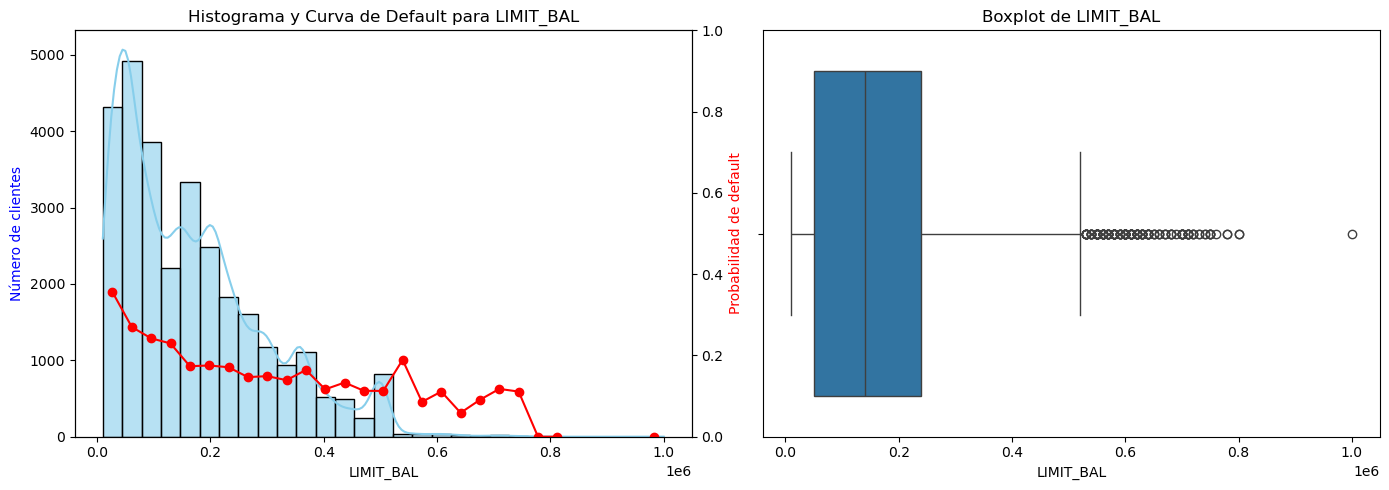

In [60]:
graficar_distribucion_default(df_base, 'LIMIT_BAL')

Se observa una tendencia logica de la distribución, donde se tiene un mayor volumen de prestamos con bajos importes y una menor materialidad de prestamos de importes elevados. Al haber más prestamos con bajos importes, tambien existe mayor probabilidad de impagar, tal y como se evidencia en la curva roja.

### AGE

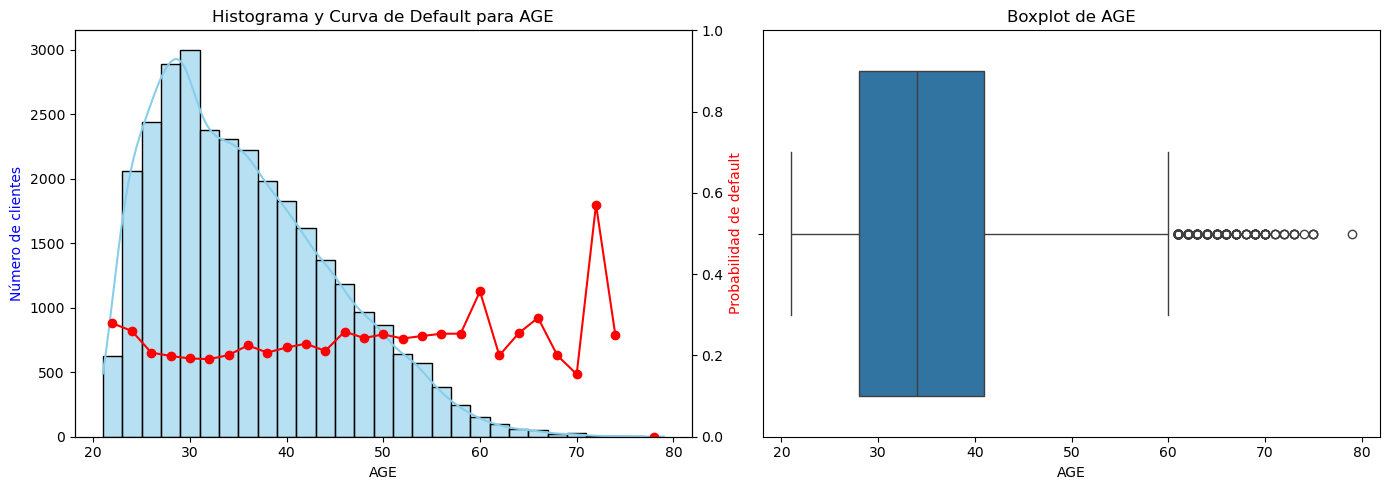

In [61]:
graficar_distribucion_default(df_base, 'AGE')

En primer lugar, en cuanto a la distribución se encuentra una tendencia con sentido, con poca gente joven y mayor, y con gente adulta como predominante (son los que logicamente piden más préstamos). En cuanto a la TD, se observa un leve incremento en las personas muy jovenes (<25 años aproximadamente), pero la tendencia se mantiene relativamente estable de ahi en adelante, con una leve tendencia a incrementar con la edad, lo que tambien hace sentido.

### BILL_AMT

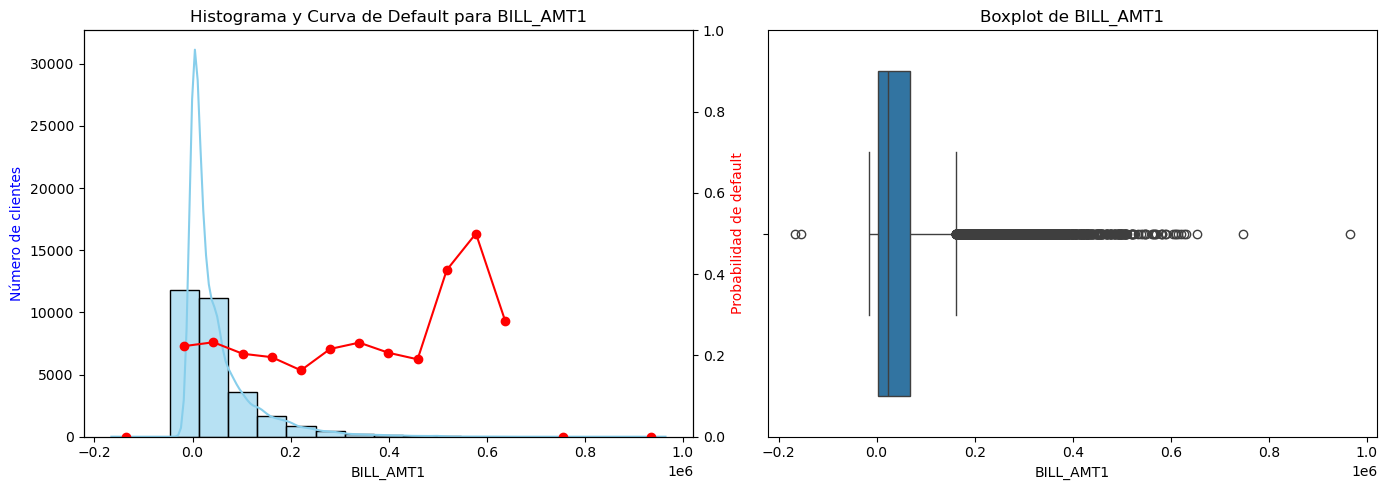

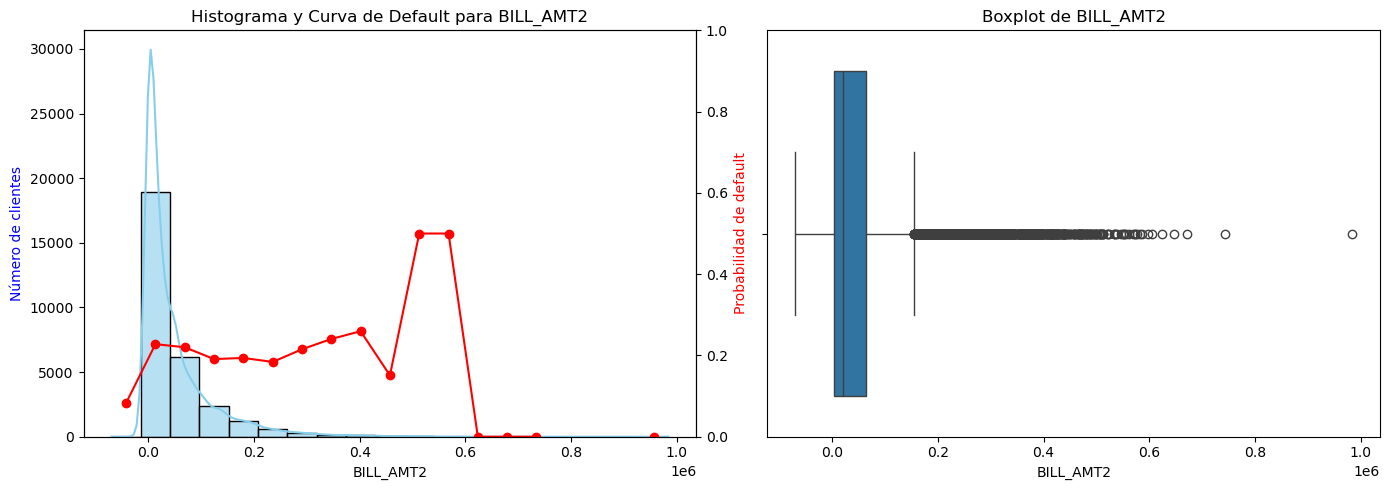

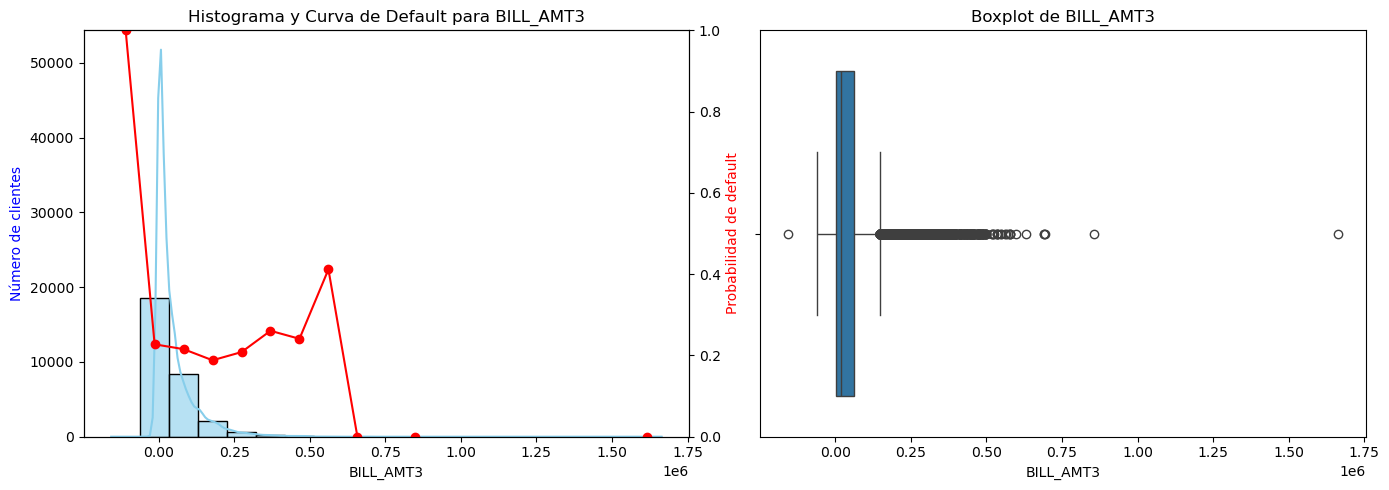

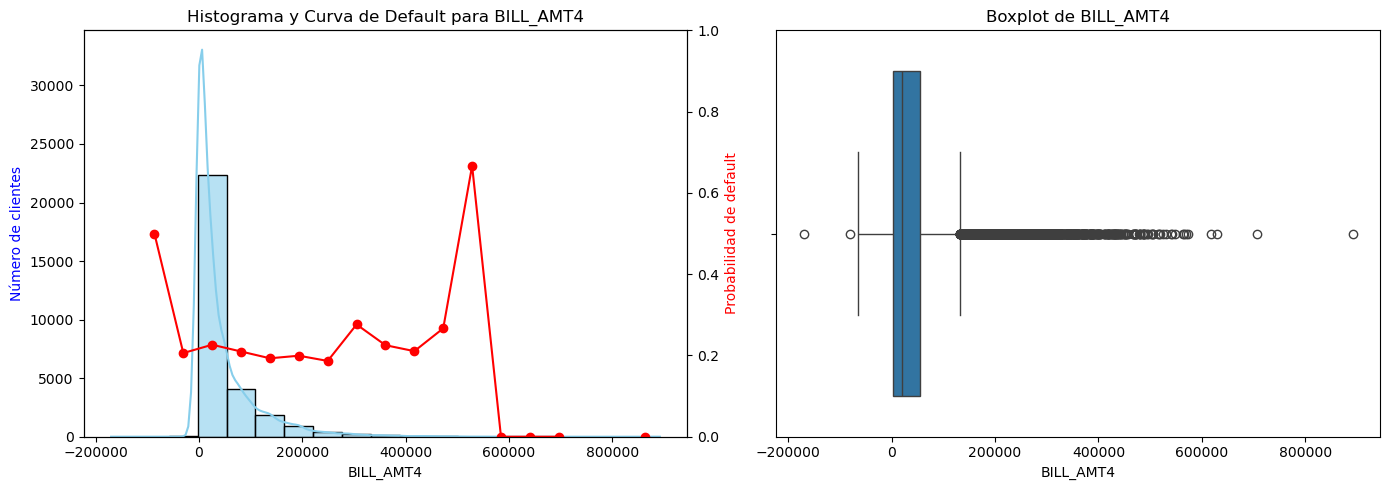

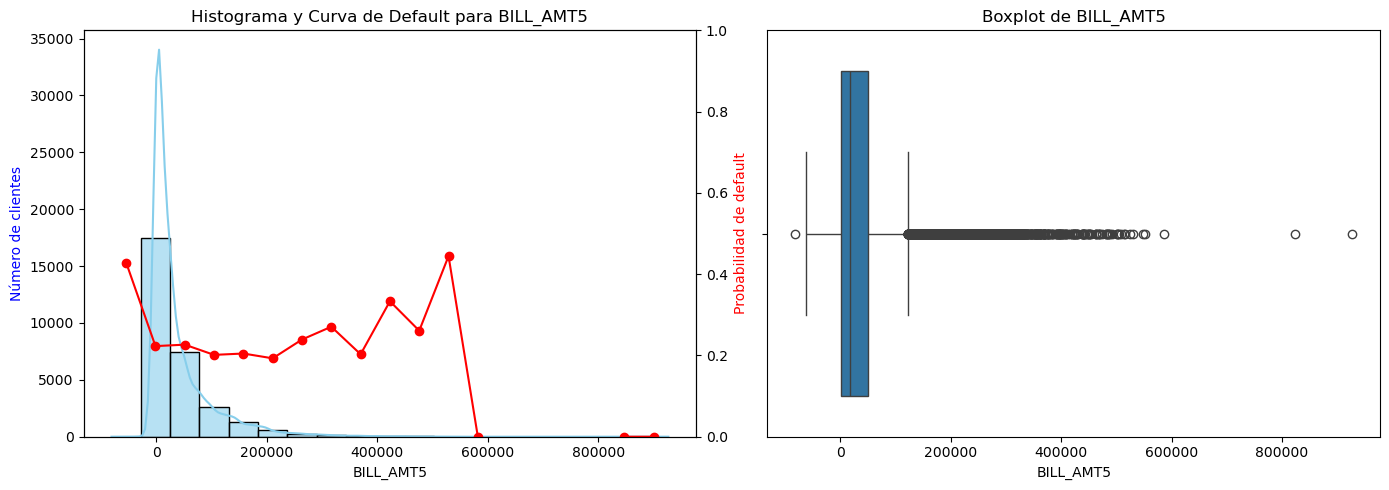

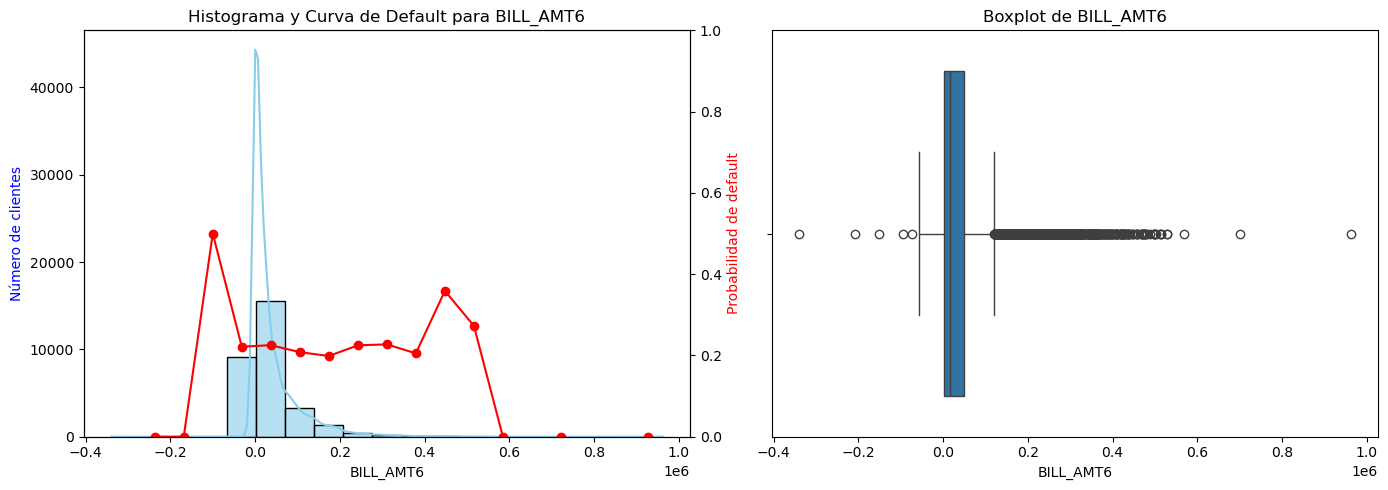

In [62]:
# Crear histogramas + boxplots juntos
for col in [col for col in vbles_numericas if 'BILL_AMT' in col]:

    graficar_distribucion_default(df_base, col, bins=20)

Lo primero a resaltar es que es extraño observar importes negativos de BILL_AMT. No obstante, estos no necesariamente son errores, sino que son saldos a favor del cliente, bien por errores de la entidad, porque el cliente haya pagado de más en facturas anteriores, correcciones de saldo, etc.

Por otro lado, en cuanto a los importes positivos, se puede ver una tendencia logica, con muchas facturas de importes más bajos y con pocas facturas de importes más altos. De hecho, existe una predominancia de facturas con importes más bajos frente a los de grandes importes, por lo que la distribución del histograma queda muy picuda y con muy pocos registros en los extremos. Esto último, convierte complicado de relacionar con las TD, puesto que se ve mucho ruido dado el poco volumen de clientes.

### PAY_AMT

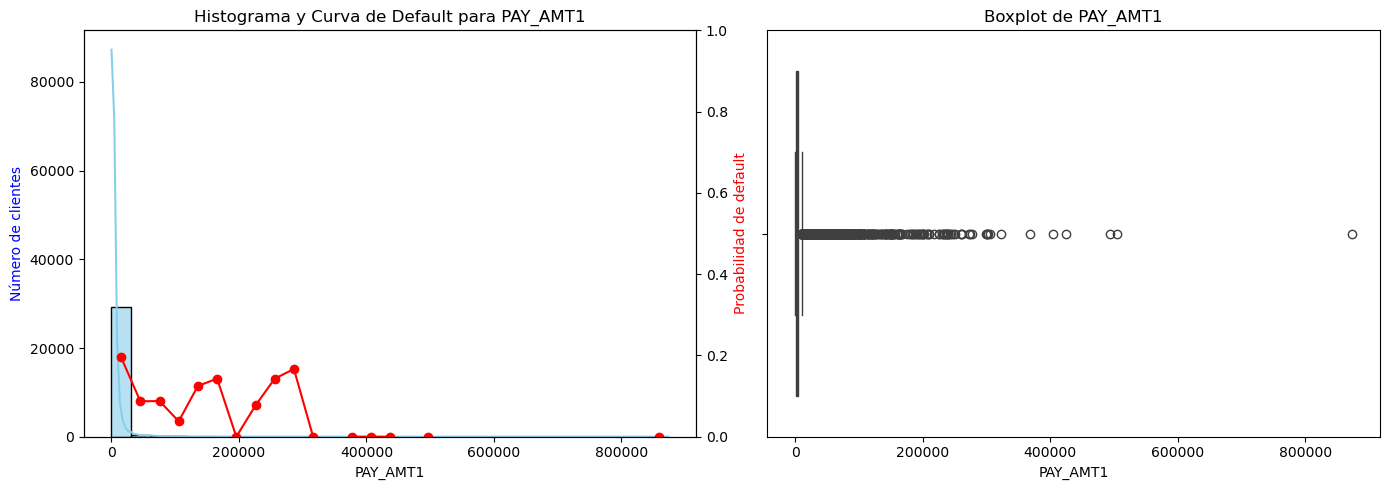

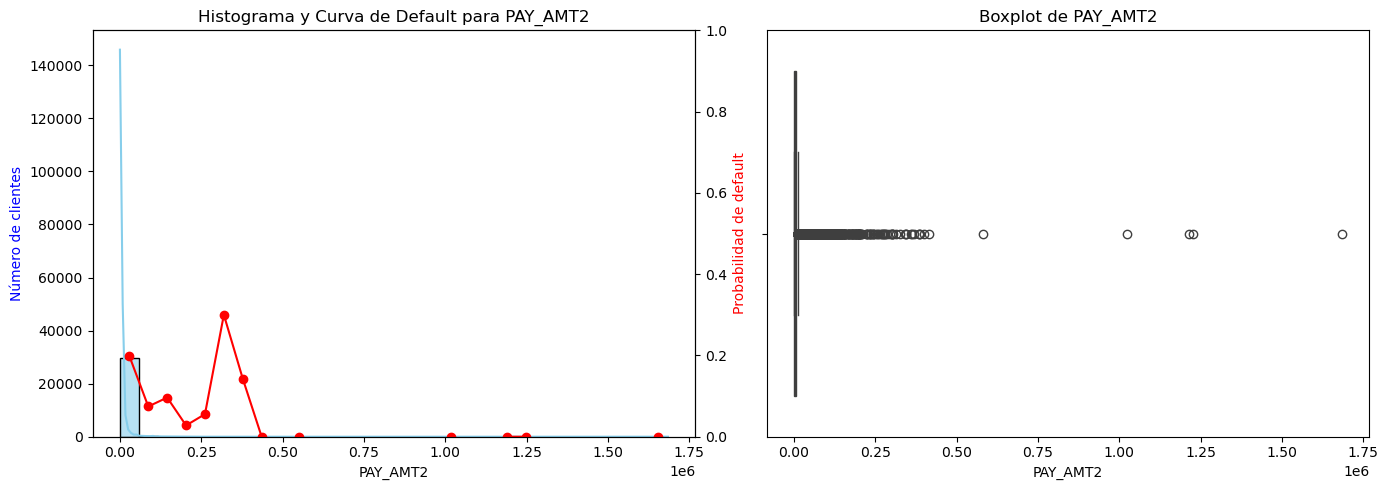

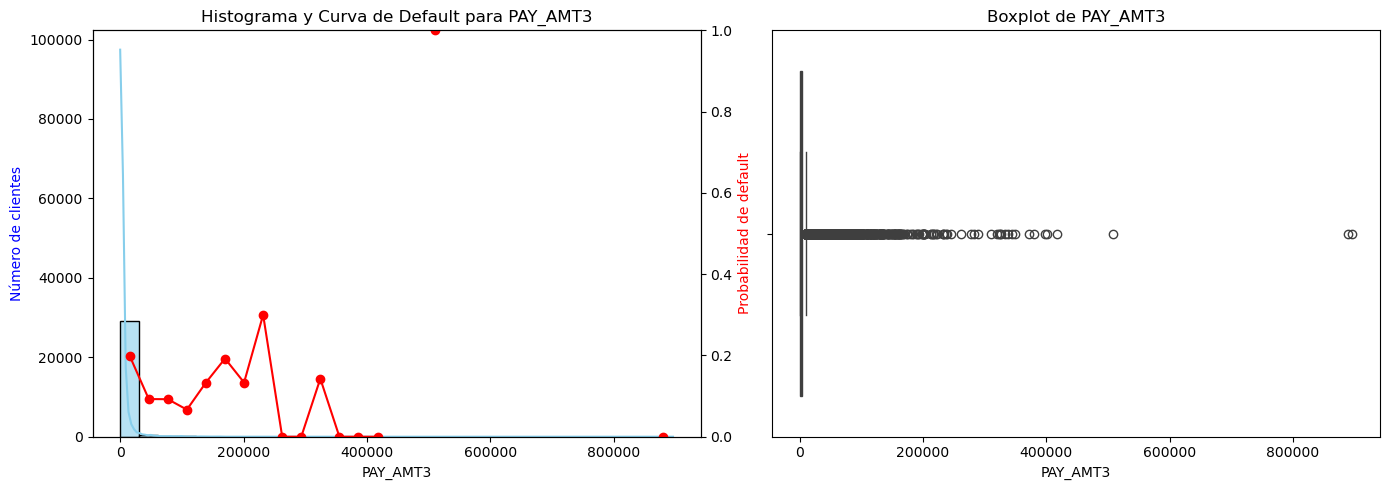

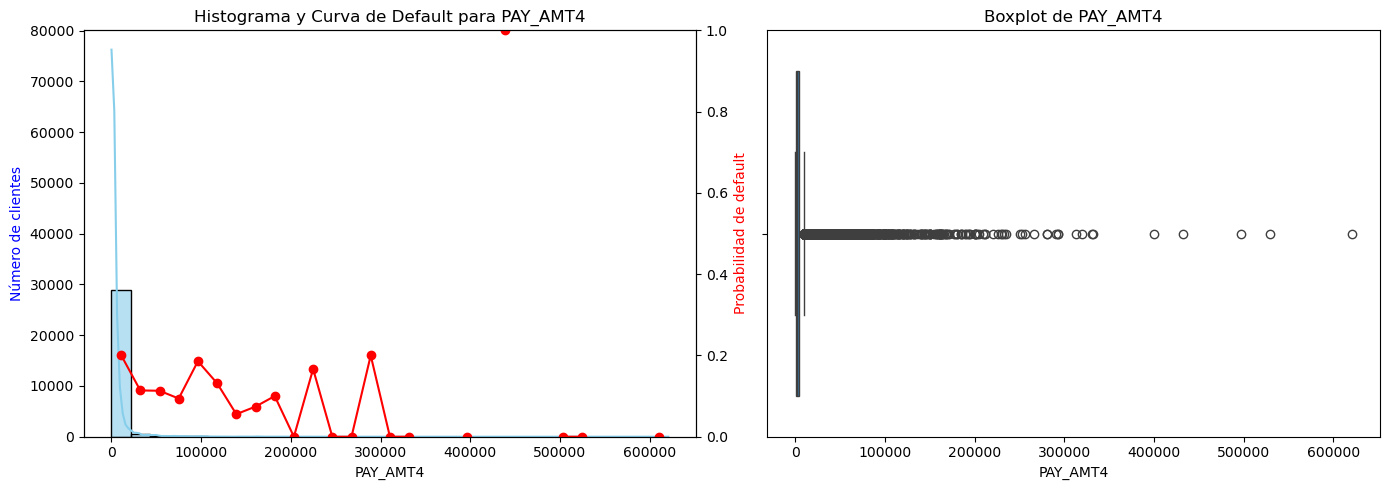

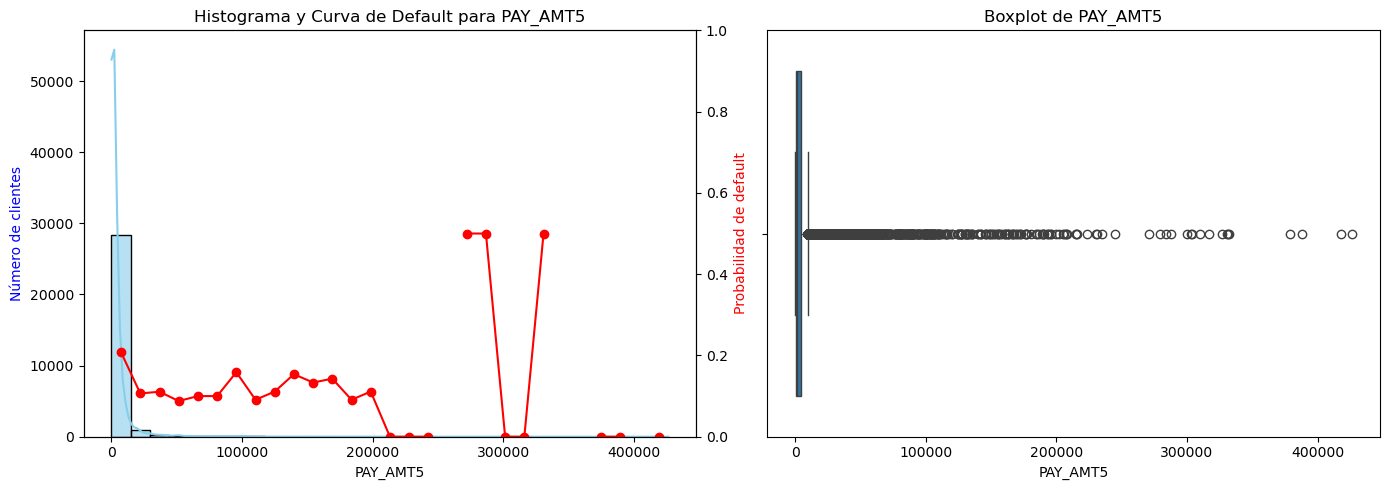

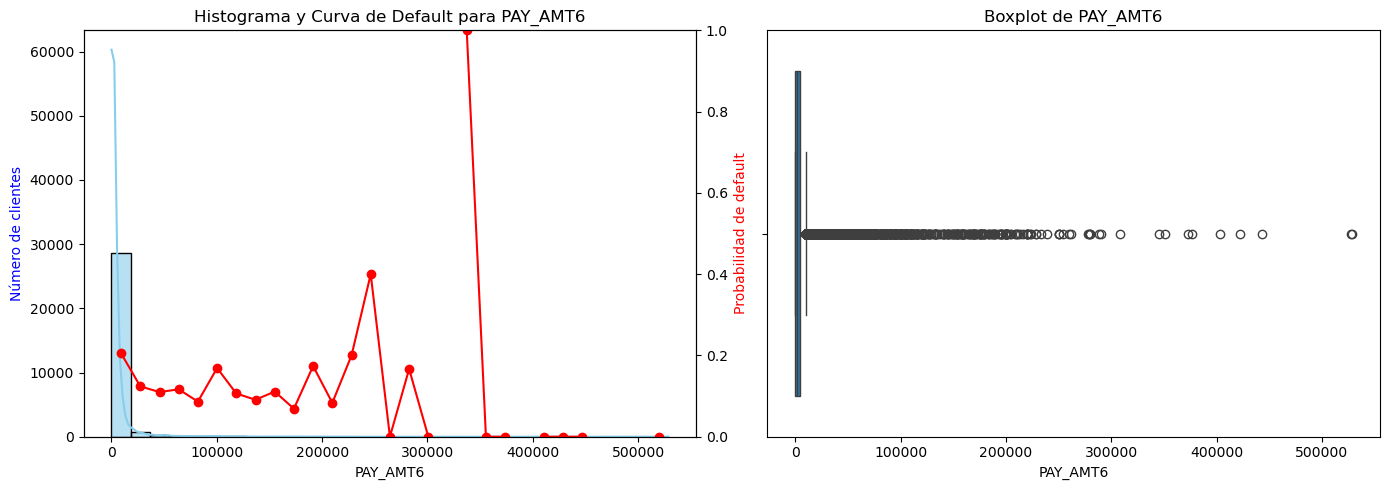

In [63]:
# Crear histogramas + boxplots juntos
for col in [col for col in vbles_numericas if 'PAY_AMT' in col]:

    graficar_distribucion_default(df_base, col)

Nuevamente, se observa que predomina los pagos de importes bajos, con escasos casos de pagos grandes que hacen que la interpretacion de la TD a lo largo de las variables de PAY_AMT sea muy ruidosa.

### RATIO_PAY_BILL

Para poder aporvechar mejor estas dos variables (BILL_AMT y PAY_AMT), se explora el uso de un ratio que escale ambas variables. No obstante, para estos ratios, se calculan los importes acumulados de BILL y de PAY, puesto que lo que interesa es saber "cuanto deberia haber pagado hasta el momento X" y "cuanto ha pagado hasta el momento X", mas que una visión por factura (habra facturas que haya podido pagar muy bien, y otras que muy mal; lo que me interesa es el agregado).

In [64]:
# Crear columnas acumulativas de BILL_AMT y PAY_AMT

# Variables originales
cols_bill = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
cols_pay = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Crear acumulados y ratios
for i in range(1, 7):  # del 1 al 6
    # Columnas a sumar hasta el mes i
    cols_bill_sum = cols_bill[:i]
    cols_pay_sum = cols_pay[:i]
    
    # Crear columnas acumulativas
    df_base[f'BILL_AMT_ACUM{i}'] = df_base[cols_bill_sum].sum(axis=1)
    df_base[f'PAY_AMT_ACUM{i}'] = df_base[cols_pay_sum].sum(axis=1)
    
    # Crear ratio acumulativo
    df_base[f'RATIO_PAY_BILL_ACUM{i}'] = df_base[f'PAY_AMT_ACUM{i}'] / df_base[f'BILL_AMT_ACUM{i}']

    # Si BILL_AMT_ACUM es 0, entonces el RATIO_PAY_BILL_ACUM debe ser 1 (se ha pagado todo)
    df_base.loc[df_base[f'BILL_AMT_ACUM{i}'] == 0, f'RATIO_PAY_BILL_ACUM{i}'] = 1
    
    # Limitar los valores de los ratios
    df_base[f'RATIO_PAY_BILL_ACUM{i}'] = df_base[f'RATIO_PAY_BILL_ACUM{i}'].clip(lower=0, upper=1)  # Limitar entre 0 y 1

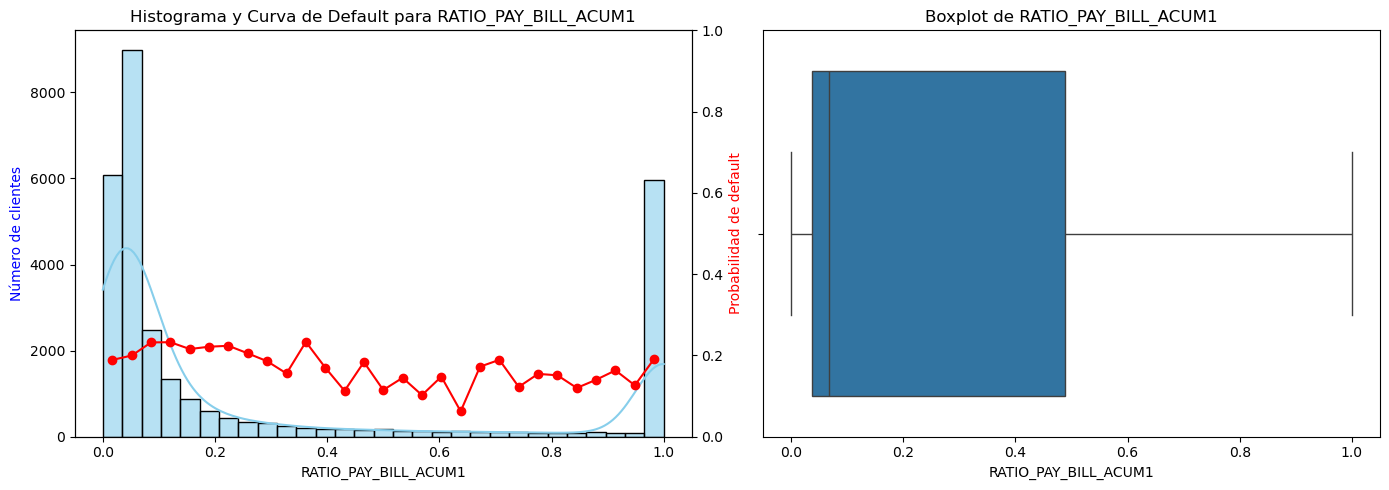

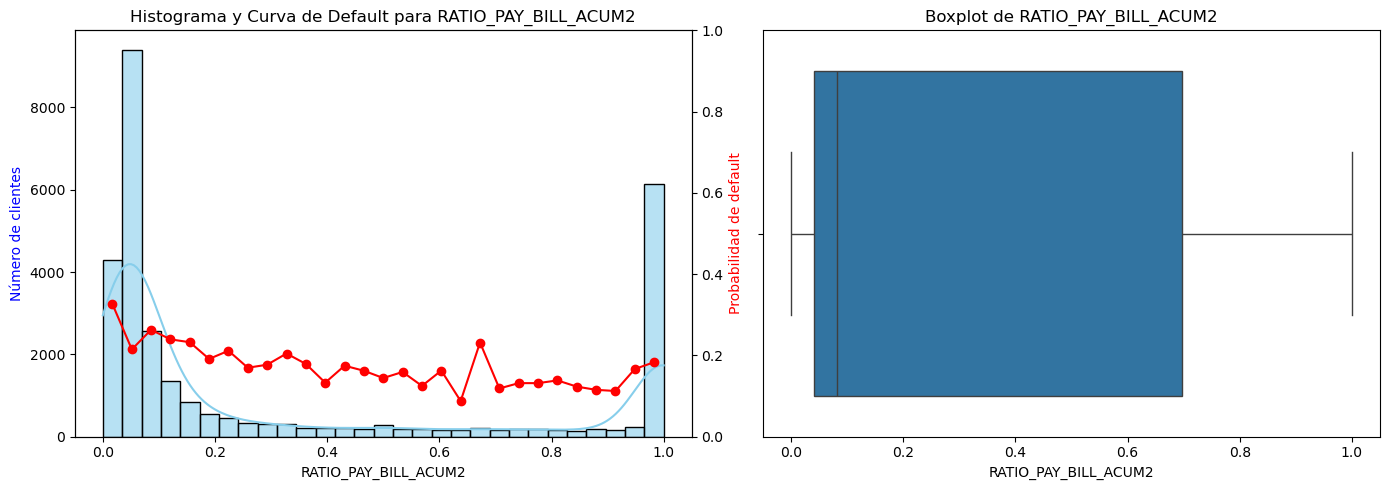

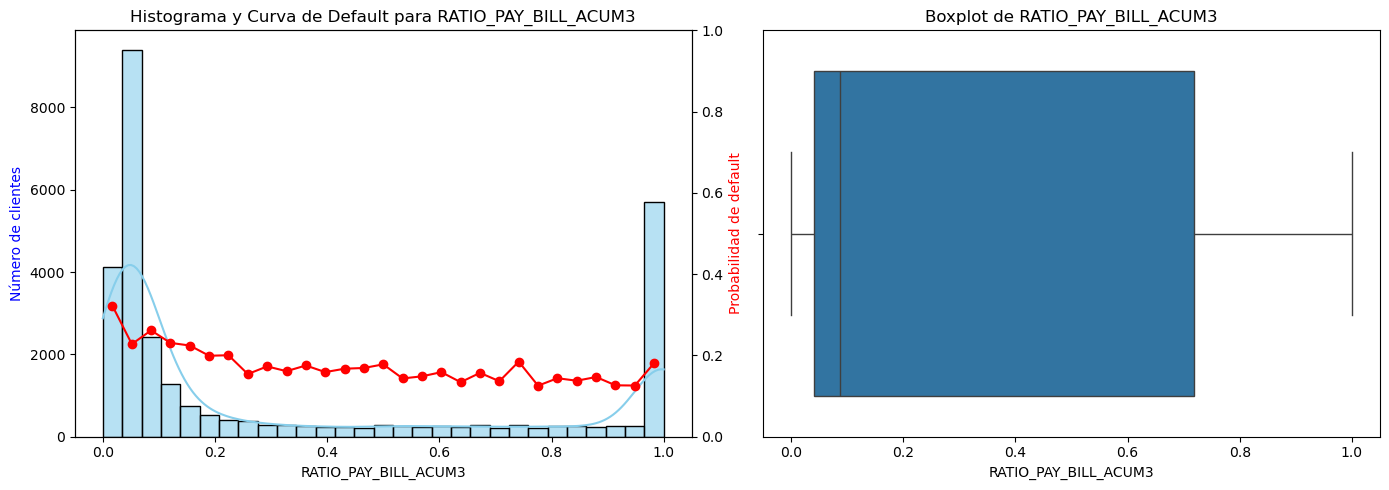

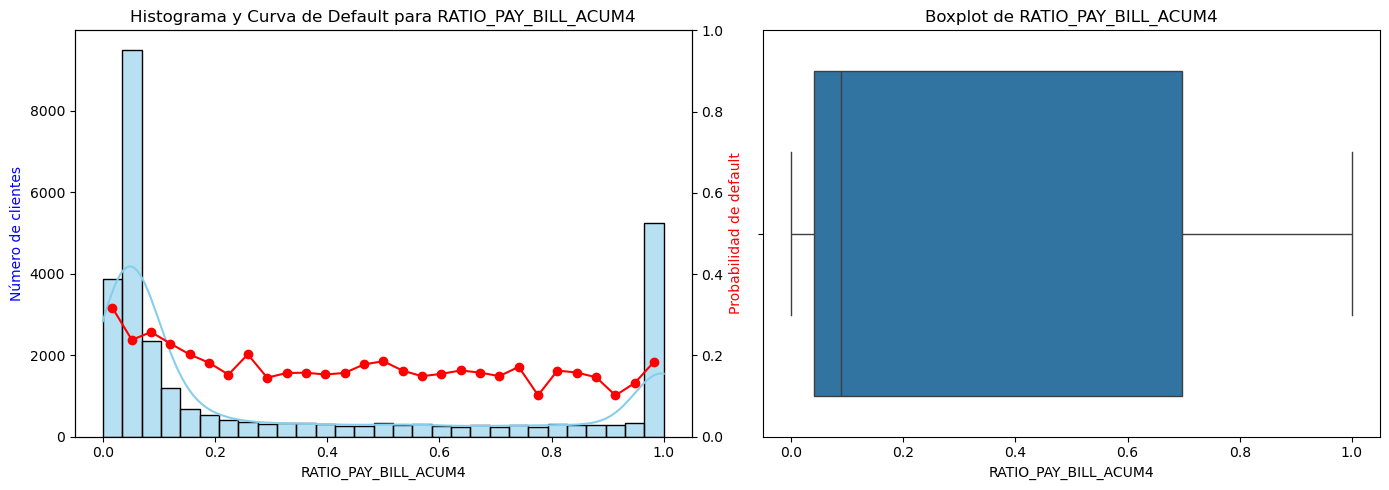

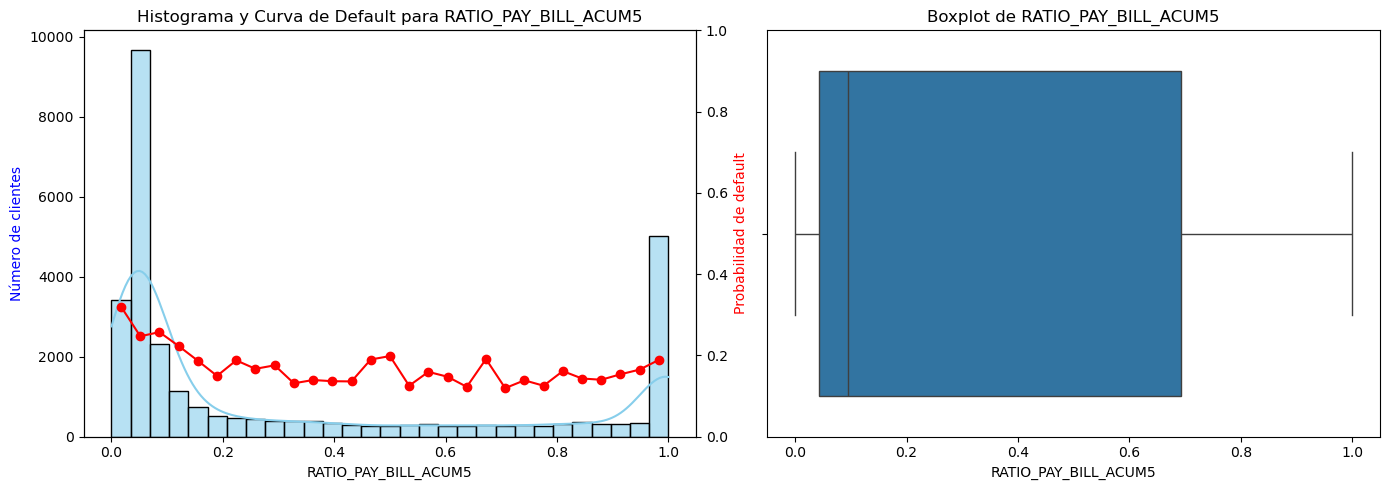

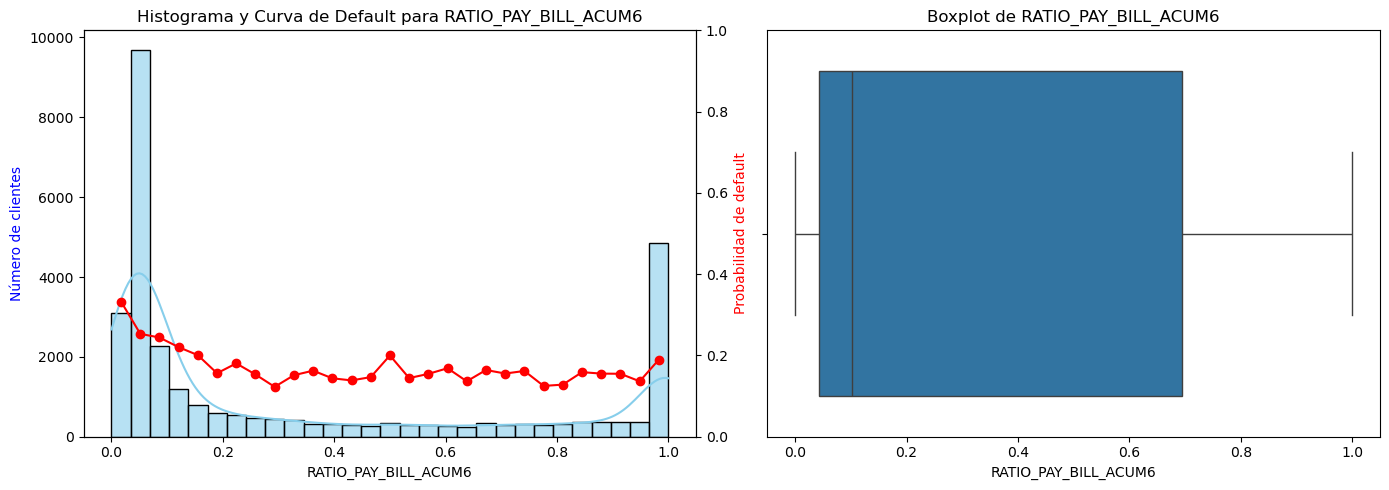

In [65]:
# Crear histogramas + boxplots juntos
for i in range(1, 7):  # del 1 al 6

    graficar_distribucion_default(df_base, f'RATIO_PAY_BILL_ACUM{i}')

De esta nueva manera, se puede tener una escala comparable para medir qué porcentaje de lo debido a podido pagar el cliente, observandose una peor morosidad en valores cercanos al 0% del ratio y una mejor en los cercanos al 100%. Adicionalmente, mencionar que gracias al boxplot se puede osbervar que la mayoría de los clientes va con retrasos en sus pagos, estando el IQR entre el 10% y el 65% pagado.

# Entrenamiento y Evaluación de Modelos

Previo al entrenamiento de los modelos, realizaremos un ejercicio de tratamiento de variables, para obtener mejores resultados. Aunque previamente ya hayamos realizado ciertos ajustes obvios, en esta sección evaluaremos todo tipo de tratamientos para todas las variables disponibles.

## Data preprocessing

### Outliers

In [66]:
numeric_cols = ["LIMIT_BAL", "AGE", "RATIO_PAY_BILL_ACUM1", "RATIO_PAY_BILL_ACUM2",
                "RATIO_PAY_BILL_ACUM3", "RATIO_PAY_BILL_ACUM4", "RATIO_PAY_BILL_ACUM5", "RATIO_PAY_BILL_ACUM6"]

df_IQR, resumen_IQR = analizar_outliers_IQR(df_base, numeric_cols)
df_percentil, resumen_percentil = analizar_outliers_percentil(df_base, numeric_cols)

# Mostrar los resúmenes
print("\nResumen por IQR:")
print(resumen_IQR)

print("\nResumen por Percentil 1-99:")
print(resumen_percentil)


Resumen por IQR:
               Variable  Total Registros  Porcentaje IQR (%)  MAX Original  MIN Original  MAX después de Acotar IQR  MIN después de Acotar IQR
1                   AGE            30000            0.906667          79.0          21.0                       60.5                       21.0
0             LIMIT_BAL            30000            0.556667     1000000.0       10000.0                   525000.0                    10000.0
2  RATIO_PAY_BILL_ACUM1            30000            0.000000           1.0           0.0                        1.0                        0.0
3  RATIO_PAY_BILL_ACUM2            30000            0.000000           1.0           0.0                        1.0                        0.0
4  RATIO_PAY_BILL_ACUM3            30000            0.000000           1.0           0.0                        1.0                        0.0
5  RATIO_PAY_BILL_ACUM4            30000            0.000000           1.0           0.0                        1.0         

Analizando los resultados, se observa mejores resultados usando los percentiles 1-99, puesto que el IQR es demasiado agresivo para RATIO_PAY_BILL_ACUM1, por lo que se elige los percentiles como metodología final de acotación. No obstante, los resultados tampoco deberían de ser muy diferentes de haber elegido el IQR.

In [67]:
df_base = df_percentil.copy()

df_base.rename(columns=lambda col: col.replace('_acot2', '_acot') if col.endswith('_acot2') else col, inplace=True)

### WOE (Numéricas)

Se agrupan las variables numericas en base a un WOE binning (agrupaciones por WOE diferenciado), asignando el valor del WOE a cada agrupación. Con esto último, se generalizan las linealidades al identificar cada agrupacion con un valor logaritmico, y normalizado a una escala comparabale de afectación sobre la variable objetivo (a diferencia de una categorizacion ordinal). 

Es decir, en vez de categorizar las agrupaciones como 1, 2 o 3, tomarán los valores 1.32, 0.56 y -1.81 (su WOE).

In [68]:
vbles_continuas = ['LIMIT_BAL', 'AGE', 
                   'LIMIT_BAL_acot', 'AGE_acot',
                   "RATIO_PAY_BILL_ACUM1", "RATIO_PAY_BILL_ACUM2",
                    "RATIO_PAY_BILL_ACUM3", "RATIO_PAY_BILL_ACUM4", "RATIO_PAY_BILL_ACUM5", "RATIO_PAY_BILL_ACUM6",
                   "RATIO_PAY_BILL_ACUM1_acot", "RATIO_PAY_BILL_ACUM2_acot",
                    "RATIO_PAY_BILL_ACUM3_acot", "RATIO_PAY_BILL_ACUM4_acot", "RATIO_PAY_BILL_ACUM5_acot", "RATIO_PAY_BILL_ACUM6_acot"]

df_base, woe_tablas = aplicar_woe_optbinning(df_base, vbles_continuas)


📊 WOE binning para variable: LIMIT_BAL
                           Bin  Count  Count (%)  Event rate       WoE
0             (-inf, 25000.00)   2471   0.082367    0.362202 -0.692865
1         [25000.00, 45000.00)   1840   0.061333    0.358696 -0.677657
2         [45000.00, 75000.00)   4921   0.164033    0.269864 -0.263374
3        [75000.00, 125000.00)   4580   0.152667    0.242795 -0.121269
4       [125000.00, 165000.00)   3282   0.109400    0.198355  0.137923
5       [165000.00, 205000.00)   3284   0.109467    0.174482    0.2955
6       [205000.00, 245000.00)   2555   0.085167    0.167906  0.341854
7       [245000.00, 365000.00)   4591   0.153033    0.151165  0.466803
8             [365000.00, inf)   2476   0.082533    0.118740   0.74573
9                      Special      0   0.000000    0.000000       0.0
10                     Missing      0   0.000000    0.000000       0.0
Totals                          30000   1.000000    0.221200          
ℹ️ IV de LIMIT_BAL con solver 'cp': 0

### WOE (Categoricas)

In [69]:
vbles_categoricas = ['SEX', 'EDUCATION_aj', 'MARRIAGE_aj', "PAY_0_aj", "PAY_2_aj", "PAY_3_aj", "PAY_4_aj", "PAY_5_aj", "PAY_6_aj"]

df_base, woe_tablas_categoricas = aplicar_woe_optbinning(df_base, vbles_categoricas, tipo="categorical")


📊 WOE binning para variable: SEX
            Bin  Count  Count (%)  Event rate       WoE
0           [2]  18112   0.603733    0.207763  0.079777
1           [1]  11888   0.396267    0.241672 -0.115154
2       Special      0   0.000000    0.000000       0.0
3       Missing      0   0.000000    0.000000       0.0
Totals           30000   1.000000    0.221200          
ℹ️ IV de SEX con solver 'cp': 0.0038

📊 WOE binning para variable: EDUCATION_aj
            Bin  Count  Count (%)  Event rate       WoE
0        [4, 1]  11053   0.368433    0.187189  0.209693
1           [2]  14030   0.467667    0.237349 -0.091416
2           [3]   4917   0.163900    0.251576 -0.168463
3       Special      0   0.000000    0.000000       0.0
4       Missing      0   0.000000    0.000000       0.0
Totals           30000   1.000000    0.221200          
ℹ️ IV de EDUCATION_aj con solver 'cp': 0.0153

📊 WOE binning para variable: MARRIAGE_aj
            Bin  Count  Count (%)  Event rate       WoE
0           [2

### Comparativa

En cuanto a las variables numericas, se consigue tener:

1. Su version original
2. Su version acotada
3. La version original convertida en WOE
4. La version acotada convertida en WOE

Como no es optimo incluir todas estas al entrenamiento del modelo, se realiza una comparativa previa para ver qué versión tiene un mejor poder predictivo entre las 4 opciones, realizando una comparativa según el AUC.

In [70]:
variables_base = ['LIMIT_BAL', 'AGE', 
                  'RATIO_PAY_BILL_ACUM1', 'RATIO_PAY_BILL_ACUM2', 
                  'RATIO_PAY_BILL_ACUM3', 'RATIO_PAY_BILL_ACUM4', 
                  'RATIO_PAY_BILL_ACUM5', 'RATIO_PAY_BILL_ACUM6']

# Ejecutar análisis
resumen_auc = comparar_versiones_auc_resumen(df_base, 'default payment next month', variables_base)

print(resumen_auc)

               VARIABLE    AUC_og  AUC_og_WOE  AUC_acot  AUC_acot_WOE Mejor versión
0             LIMIT_BAL  0.617803    0.618294  0.617801      0.618294           WOE
1                   AGE  0.503579    0.541413  0.503575      0.541413           WOE
2  RATIO_PAY_BILL_ACUM1  0.561582    0.573281  0.561582      0.573281           WOE
3  RATIO_PAY_BILL_ACUM2  0.565143    0.579578  0.565143      0.579578           WOE
4  RATIO_PAY_BILL_ACUM3  0.571382    0.580262  0.571382      0.580262           WOE
5  RATIO_PAY_BILL_ACUM4  0.572966    0.580826  0.572966      0.580826           WOE
6  RATIO_PAY_BILL_ACUM5  0.575170    0.584450  0.575170      0.584450           WOE
7  RATIO_PAY_BILL_ACUM6  0.577405    0.586032  0.577405      0.586032           WOE


Se observa que la versión más predictiva para el modelo va a ser la del WOE, sin considerar acotaciones previas (ya el propio WOE implicitamente trata los valores atipicos)

## Entrenamiento

#### Random Forest

En cuanto a las variables categoricas, se incluyen aquellas transformaciones por WOE, debido a que:

1. Ofrecen un mayor poder predictivo respecto a la variable target, puesto que o bien se han mantenido con la agrupación original o bien se han re-agrupado para tener mayor capacidad discriminante.

2. Al identificarlas por su WOE, pasan de ser variables categoricas a "numericas", por lo que pueden ser normalizadas (StandardScaler).

En cuanto a las variables numericas, incluimos las que han salido como mejores en la comparativa del apartado anterior.

In [613]:
features = ["SEX_WOE", "EDUCATION_aj_WOE", "MARRIAGE_aj_WOE", "PAY_0_aj_WOE", "PAY_2_aj_WOE", "PAY_3_aj_WOE", "PAY_4_aj_WOE", "PAY_5_aj_WOE", "PAY_6_aj_WOE",
            "AGE_WOE", "LIMIT_BAL_WOE","RATIO_PAY_BILL_ACUM1_WOE", "RATIO_PAY_BILL_ACUM2_WOE", "RATIO_PAY_BILL_ACUM3_WOE","RATIO_PAY_BILL_ACUM4_WOE",
             "RATIO_PAY_BILL_ACUM5_WOE", "RATIO_PAY_BILL_ACUM6_WOE"]

Estas son las variables que mejor poder predictivo tienen, pero eso no implica que incluirlas todas sea lo más optimo para el modelo. Para saber cuáles de ellas otorgan el mayor rendimiento, se propone un proceso stepwise, en el que se van incluyendo / eliminando las variables una a una según el poder predictivo que sumen / resten al modelo final.

Nota: en las siguientes celdas se ha dejado solamente la llamada a la funcion de entrenamiento del modelo, disponible en la sección Funciones, para que el codigo sea mas ordenado. Aunque se pueda analizar en detalle el codigo ahi, se resumen las principales caracteristicas en la siguiente lista (aplicable para los demas modelos como GBM y LOGREG):

- Utiliza una estrategia de selección de variables tipo stepwise forward, añadiendo variables solo si mejoran una métrica objetivo (AUC, F1, recall, etc.) por encima de un umbral (threshold).

- Permite corregir el desbalance de clases mediante dos enfoques: SMOTE (use_smote=True) o class_weight='balanced' en el modelo.

- Realiza una división estratificada de los datos en entrenamiento (70%) y test (30%).

- Aplica escalado estándar a las variables predictoras mediante StandardScaler.

- Evalúa el rendimiento con métricas ajustables: AUC, F1, precisión, recall o accuracy.

- Implementa validación cruzada estratificada (K-Fold) para evaluar el rendimiento del modelo.

- Devuelve un resumen detallado con métricas de rendimiento, matriz de confusión y variables seleccionadas.

- Imprime el proceso paso a paso y se detiene automáticamente si no hay mejora significativa en la métrica.

In [614]:
target = 'default payment next month'

# Balanced
fila_rf_auc = stepwise_rf_selection(df_base, features, target, metric='auc', use_smote=False)
fila_rf_recall = stepwise_rf_selection(df_base, features, target, metric='recall', use_smote=False)
fila_rf_f1 = stepwise_rf_selection(df_base, features, target, metric='f1', use_smote=False)

# SMOTE
fila_rf_auc_smote = stepwise_rf_selection(df_base, features, target, metric='auc', use_smote=True)
fila_rf_recall_smote = stepwise_rf_selection(df_base, features, target, metric='recall', use_smote=True)
fila_rf_f1_smote = stepwise_rf_selection(df_base, features, target, metric='f1', use_smote=True)


🔍 Iniciando selección stepwise con Random Forest | Métrica: AUC | (Balanced)
✅ Agregada: PAY_0_aj_WOE | AUC: 0.7032
✅ Agregada: LIMIT_BAL_WOE | AUC: 0.7370
✅ Agregada: PAY_3_aj_WOE | AUC: 0.7441
🛑 No mejora significativa. Finalizando selección.

=== RESUMEN ===
  MODELO METODOLOGIA METRICA_STEPWISE       AUC  ACCURACY  PRECISION    RECALL        F1    TN    FP   FN    TP  N_FEATURES                            FEATURES_USADAS
0     RF    Balanced              AUC  0.744132  0.772889   0.487703  0.527875  0.506995  5905  1104  940  1051           3  PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE

🔍 Iniciando selección stepwise con Random Forest | Métrica: RECALL | (Balanced)
✅ Agregada: RATIO_PAY_BILL_ACUM2_WOE | RECALL: 0.6996
🛑 No mejora significativa. Finalizando selección.

=== RESUMEN ===
  MODELO METODOLOGIA METRICA_STEPWISE       AUC  ACCURACY  PRECISION    RECALL        F1    TN    FP   FN    TP  N_FEATURES           FEATURES_USADAS
0     RF    Balanced           RECALL  0.581745  0.

In [630]:
# Combinar y mostrar
resumen_total_rf = [
    fila_rf_auc, fila_rf_recall, fila_rf_f1,
    fila_rf_auc_smote, fila_rf_recall_smote, fila_rf_f1_smote
]

resumen_df_rf = pd.DataFrame(resumen_total_rf)
print("\n📊 Tabla comparativa - Random Forest:")
resumen_df_rf


📊 Tabla comparativa - Random Forest:


,MODELO,METODOLOGIA,METRICA_STEPWISE,AUC,ACCURACY,PRECISION,RECALL,F1,TN,FP,FN,TP,N_FEATURES,FEATURES_USADAS
0,RF,Balanced,AUC,0.744132,0.772889,0.487703,0.527875,0.506995,5905,1104,940,1051,3,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE"
1,RF,Balanced,RECALL,0.581745,0.471889,0.251081,0.699648,0.369545,2854,4155,598,1393,1,RATIO_PAY_BILL_ACUM2_WOE
2,RF,Balanced,F1,0.734138,0.765111,0.474513,0.575088,0.519982,5741,1268,846,1145,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"
3,RF,SMOTE,AUC,0.744240,0.770556,0.483318,0.538423,0.509385,5863,1146,919,1072,3,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE"
4,RF,SMOTE,RECALL,0.581745,0.471889,0.251081,0.699648,0.369545,2854,4155,598,1393,1,RATIO_PAY_BILL_ACUM2_WOE
5,RF,SMOTE,F1,0.734513,0.756889,0.461538,0.593672,0.519332,5630,1379,809,1182,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"


Se puede ver que entre usar SMOTE o el balanceo de clases los resultados obtenidos son similares, por lo que resulta indiferente usar una metodologia u otra.

En cuanto a la metrica utilizada para el stepwise, se puede ver que la opcion del F1 ofrece un equilibrio entre si se usa el AUC, donde solamente se mide el AUC, y la segunda, donde solamente se mide el Recall. Con la opcion del F1, se obtiene el mejor equilibrio entre Precision y Recall, y el AUC resultante es muy similar a si solamente se optimiza el AUC, por lo que se considera la solucion optima.

Sobre esta elección, finalmente quedaria acordar con el cliente para alinear el sentido de negocio, es decir, si se quiere dar mayor / menor peso a los verdaderos / falsos positivos / negativos, y ajustar el modelo en consecuencia.

### Gradient Boosting

In [616]:
target = 'default payment next month'

# Balanced (sin SMOTE)
fila_gbm_auc = stepwise_gbm_selection(df_base, features, target, metric='auc', use_smote=False)
fila_gbm_recall = stepwise_gbm_selection(df_base, features, target, metric='recall', use_smote=False)
fila_gbm_f1 = stepwise_gbm_selection(df_base, features, target, metric='f1', use_smote=False)

# SMOTE
fila_gbm_auc_smote = stepwise_gbm_selection(df_base, features, target, metric='auc', use_smote=True)
fila_gbm_recall_smote = stepwise_gbm_selection(df_base, features, target, metric='recall', use_smote=True)
fila_gbm_f1_smote = stepwise_gbm_selection(df_base, features, target, metric='f1', use_smote=True)


🔍 Iniciando selección stepwise con Gradient Boosting | Métrica: AUC | Sin SMOTE
✅ Agregada: PAY_0_aj_WOE | AUC: 0.7032
✅ Agregada: LIMIT_BAL_WOE | AUC: 0.7373
✅ Agregada: PAY_3_aj_WOE | AUC: 0.7469
✅ Agregada: RATIO_PAY_BILL_ACUM5_WOE | AUC: 0.7510
✅ Agregada: PAY_2_aj_WOE | AUC: 0.7530
✅ Agregada: PAY_6_aj_WOE | AUC: 0.7555
✅ Agregada: RATIO_PAY_BILL_ACUM2_WOE | AUC: 0.7573
✅ Agregada: MARRIAGE_aj_WOE | AUC: 0.7597
✅ Agregada: PAY_4_aj_WOE | AUC: 0.7608
✅ Agregada: SEX_WOE | AUC: 0.7619
🛑 No mejora significativa. Finalizando selección.

=== RESUMEN ===
  MODELO METODOLOGIA METRICA_STEPWISE       AUC  ACCURACY  PRECISION    RECALL       F1    TN   FP    FN   TP  N_FEATURES                                    FEATURES_USADAS
0    GBM    No SMOTE              AUC  0.761944  0.817556   0.659361  0.362632  0.46792  6636  373  1269  722          10  PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, RAT...

🔍 Iniciando selección stepwise con Gradient Boosting | Métrica: RECALL | Sin SMOTE
✅ Agregad

In [629]:
# Construir la tabla resumen
resumen_total_gbm = [
    fila_gbm_auc, fila_gbm_recall, fila_gbm_f1,
    fila_gbm_auc_smote, fila_gbm_recall_smote, fila_gbm_f1_smote
]

resumen_df_gbm = pd.DataFrame(resumen_total_gbm)
print("\n📊 Tabla comparativa - Gradient Boosting:")
resumen_df_gbm


📊 Tabla comparativa - Gradient Boosting:


,MODELO,METODOLOGIA,METRICA_STEPWISE,AUC,ACCURACY,PRECISION,RECALL,F1,TN,FP,FN,TP,N_FEATURES,FEATURES_USADAS
0,GBM,No SMOTE,AUC,0.761944,0.817556,0.659361,0.362632,0.467920,6636,373,1269,722,10,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, RATIO_PAY_BILL_ACUM5_WOE, PAY_2_aj_WOE, PAY_6_aj_WOE, RATIO_PAY_BILL_ACUM2_WOE, MARRIAGE_aj_WOE, PAY_4_aj_WOE, SEX_WOE"
1,GBM,No SMOTE,RECALL,0.645788,0.794111,0.552273,0.366148,0.440350,6418,591,1262,729,1,PAY_2_aj_WOE
2,GBM,No SMOTE,F1,0.719487,0.817000,0.647009,0.380211,0.478962,6596,413,1234,757,2,"PAY_0_aj_WOE, PAY_4_aj_WOE"
3,GBM,SMOTE,AUC,0.753045,0.769111,0.480778,0.546459,0.511519,5834,1175,903,1088,6,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, PAY_6_aj_WOE, PAY_4_aj_WOE, RATIO_PAY_BILL_ACUM5_WOE"
4,GBM,SMOTE,RECALL,0.581745,0.471889,0.251081,0.699648,0.369545,2854,4155,598,1393,1,RATIO_PAY_BILL_ACUM2_WOE
5,GBM,SMOTE,F1,0.726066,0.759333,0.464845,0.581115,0.516518,5677,1332,834,1157,3,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE"


### Regresión Logística

In [625]:
target = 'default payment next month'

# Balanced (sin SMOTE)
fila_logreg_auc = stepwise_logreg_selection(df_base, features, target, metric='auc', use_smote=False)
fila_logreg_recall = stepwise_logreg_selection(df_base, features, target, metric='recall', use_smote=False)
fila_logreg_f1 = stepwise_logreg_selection(df_base, features, target, metric='f1', use_smote=False)

# SMOTE
fila_logreg_auc_smote = stepwise_logreg_selection(df_base, features, target, metric='auc', use_smote=True)
fila_logreg_recall_smote = stepwise_logreg_selection(df_base, features, target, metric='recall', use_smote=True)
fila_logreg_f1_smote = stepwise_logreg_selection(df_base, features, target, metric='f1', use_smote=True)


🔍 Iniciando selección stepwise con Regresión Logística | Métrica: AUC | Balanced
✅ Agregada: PAY_0_aj_WOE | AUC: 0.7032
✅ Agregada: LIMIT_BAL_WOE | AUC: 0.7362
✅ Agregada: PAY_3_aj_WOE | AUC: 0.7436
✅ Agregada: SEX_WOE | AUC: 0.7454
✅ Agregada: MARRIAGE_aj_WOE | AUC: 0.7472
✅ Agregada: PAY_2_aj_WOE | AUC: 0.7488
✅ Agregada: PAY_4_aj_WOE | AUC: 0.7502
🛑 No mejora significativa. Finalizando selección.

=== RESUMEN ===
   MODELO METODOLOGIA METRICA_STEPWISE       AUC  ACCURACY  PRECISION    RECALL       F1    TN    FP   FN    TP  N_FEATURES                                                                                  FEATURES_USADAS
0  LOGREG    Balanced              AUC  0.750245  0.775889   0.494064  0.543446  0.51758  5901  1108  909  1082           7  PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, SEX_WOE, MARRIAGE_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE

🔍 Iniciando selección stepwise con Regresión Logística | Métrica: RECALL | Balanced
✅ Agregada: RATIO_PAY_BILL_ACUM2_WOE | RECALL: 0.699

In [626]:
resumen_total_logreg = [
    fila_logreg_auc, fila_logreg_recall, fila_logreg_f1,
    fila_logreg_auc_smote, fila_logreg_recall_smote, fila_logreg_f1_smote
]

resumen_df_logreg = pd.DataFrame(resumen_total_logreg)

print("\n📊 Tabla comparativa - Regresión Logística:")
resumen_df_logreg


📊 Tabla comparativa - Regresión Logística:


,MODELO,METODOLOGIA,METRICA_STEPWISE,AUC,ACCURACY,PRECISION,RECALL,F1,TN,FP,FN,TP,N_FEATURES,FEATURES_USADAS
0,LOGREG,Balanced,AUC,0.750245,0.775889,0.494064,0.543446,0.517580,5901,1108,909,1082,7,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, SEX_WOE, MARRIAGE_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"
1,LOGREG,Balanced,RECALL,0.581745,0.471889,0.251081,0.699648,0.369545,2854,4155,598,1393,1,RATIO_PAY_BILL_ACUM2_WOE
2,LOGREG,Balanced,F1,0.743637,0.772333,0.487054,0.547966,0.515717,5860,1149,900,1091,3,"PAY_0_aj_WOE, PAY_3_aj_WOE, LIMIT_BAL_WOE"
3,LOGREG,SMOTE,AUC,0.750008,0.776889,0.496078,0.539930,0.517076,5917,1092,916,1075,7,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, SEX_WOE, MARRIAGE_aj_WOE, PAY_4_aj_WOE, PAY_2_aj_WOE"
4,LOGREG,SMOTE,RECALL,0.581745,0.471889,0.251081,0.699648,0.369545,2854,4155,598,1393,1,RATIO_PAY_BILL_ACUM2_WOE
5,LOGREG,SMOTE,F1,0.744733,0.770667,0.483984,0.553993,0.516628,5833,1176,888,1103,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, LIMIT_BAL_WOE, PAY_4_aj_WOE"


### Comparativa

In [627]:
# Unir los tres resúmenes
resumen_df_total = pd.concat(
    [resumen_df_rf, resumen_df_gbm, resumen_df_logreg],
    ignore_index=True
)

# Ordenar por AUC descendente (o cualquier otra métrica si prefieres)
resumen_df_total = resumen_df_total.sort_values(by='AUC', ascending=False)

# Mostrar
print("\n📊 Comparativa final - RF vs GBM vs LOGREG:")
resumen_df_total


📊 Comparativa final - RF vs GBM vs LOGREG:


,MODELO,METODOLOGIA,METRICA_STEPWISE,AUC,ACCURACY,PRECISION,RECALL,F1,TN,FP,FN,TP,N_FEATURES,FEATURES_USADAS
6,GBM,No SMOTE,AUC,0.761944,0.817556,0.659361,0.362632,0.467920,6636,373,1269,722,10,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, RATIO_PAY_BILL_ACUM5_WOE, PAY_2_aj_WOE, PAY_6_aj_WOE, RATIO_PAY_BILL_ACUM2_WOE, MARRIAGE_aj_WOE, PAY_4_aj_WOE, SEX_WOE"
9,GBM,SMOTE,AUC,0.753045,0.769111,0.480778,0.546459,0.511519,5834,1175,903,1088,6,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, PAY_6_aj_WOE, PAY_4_aj_WOE, RATIO_PAY_BILL_ACUM5_WOE"
12,LOGREG,Balanced,AUC,0.750245,0.775889,0.494064,0.543446,0.517580,5901,1108,909,1082,7,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, SEX_WOE, MARRIAGE_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"
15,LOGREG,SMOTE,AUC,0.750008,0.776889,0.496078,0.539930,0.517076,5917,1092,916,1075,7,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, SEX_WOE, MARRIAGE_aj_WOE, PAY_4_aj_WOE, PAY_2_aj_WOE"
17,LOGREG,SMOTE,F1,0.744733,0.770667,0.483984,0.553993,0.516628,5833,1176,888,1103,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, LIMIT_BAL_WOE, PAY_4_aj_WOE"
3,RF,SMOTE,AUC,0.744240,0.770556,0.483318,0.538423,0.509385,5863,1146,919,1072,3,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE"
0,RF,Balanced,AUC,0.744132,0.772889,0.487703,0.527875,0.506995,5905,1104,940,1051,3,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE"
14,LOGREG,Balanced,F1,0.743637,0.772333,0.487054,0.547966,0.515717,5860,1149,900,1091,3,"PAY_0_aj_WOE, PAY_3_aj_WOE, LIMIT_BAL_WOE"
5,RF,SMOTE,F1,0.734513,0.756889,0.461538,0.593672,0.519332,5630,1379,809,1182,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"
2,RF,Balanced,F1,0.734138,0.765111,0.474513,0.575088,0.519982,5741,1268,846,1145,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"


Se observa que el modelo con mayor AUC es aquel con GBM optimizado usando la metrica AUC en el que no se ha hecho ningun tratamiento para ajustar la clase desbalanceada. No obstante, si analizamos el recall puede verse que este es muy bajo, por lo que no resultaria optimo en un modelo de deteccion de riesgo crediticio como este.

Por el contrario, lo mas interesante en estos modelos es tener un buen F1, pudiendo mantener paralelamente un buen AUC.

In [628]:
# Unir los tres resúmenes
resumen_df_total = pd.concat(
    [resumen_df_rf, resumen_df_gbm, resumen_df_logreg],
    ignore_index=True
)

# Ordenar por AUC descendente (o cualquier otra métrica si prefieres)
resumen_df_total = resumen_df_total.sort_values(by='F1', ascending=False)

# Mostrar
print("\n📊 Comparativa final - RF vs GBM vs LOGREG:")
resumen_df_total


📊 Comparativa final - RF vs GBM vs LOGREG:


,MODELO,METODOLOGIA,METRICA_STEPWISE,AUC,ACCURACY,PRECISION,RECALL,F1,TN,FP,FN,TP,N_FEATURES,FEATURES_USADAS
2,RF,Balanced,F1,0.734138,0.765111,0.474513,0.575088,0.519982,5741,1268,846,1145,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"
5,RF,SMOTE,F1,0.734513,0.756889,0.461538,0.593672,0.519332,5630,1379,809,1182,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"
12,LOGREG,Balanced,AUC,0.750245,0.775889,0.494064,0.543446,0.517580,5901,1108,909,1082,7,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, SEX_WOE, MARRIAGE_aj_WOE, PAY_2_aj_WOE, PAY_4_aj_WOE"
15,LOGREG,SMOTE,AUC,0.750008,0.776889,0.496078,0.539930,0.517076,5917,1092,916,1075,7,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, SEX_WOE, MARRIAGE_aj_WOE, PAY_4_aj_WOE, PAY_2_aj_WOE"
17,LOGREG,SMOTE,F1,0.744733,0.770667,0.483984,0.553993,0.516628,5833,1176,888,1103,4,"PAY_0_aj_WOE, PAY_3_aj_WOE, LIMIT_BAL_WOE, PAY_4_aj_WOE"
11,GBM,SMOTE,F1,0.726066,0.759333,0.464845,0.581115,0.516518,5677,1332,834,1157,3,"PAY_0_aj_WOE, PAY_3_aj_WOE, PAY_2_aj_WOE"
14,LOGREG,Balanced,F1,0.743637,0.772333,0.487054,0.547966,0.515717,5860,1149,900,1091,3,"PAY_0_aj_WOE, PAY_3_aj_WOE, LIMIT_BAL_WOE"
9,GBM,SMOTE,AUC,0.753045,0.769111,0.480778,0.546459,0.511519,5834,1175,903,1088,6,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE, PAY_6_aj_WOE, PAY_4_aj_WOE, RATIO_PAY_BILL_ACUM5_WOE"
3,RF,SMOTE,AUC,0.744240,0.770556,0.483318,0.538423,0.509385,5863,1146,919,1072,3,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE"
0,RF,Balanced,AUC,0.744132,0.772889,0.487703,0.527875,0.506995,5905,1104,940,1051,3,"PAY_0_aj_WOE, LIMIT_BAL_WOE, PAY_3_aj_WOE"


Si ordenamos por F1, podemos ver que hay otros modelos mejores. Concretamente, el modelo de regresion logistica optimizado usando AUC con pesos ajustados tiene uno de los F1 mas altos, y tambien uno de los AUC, por lo que se elige como el mejor candidato (fila 3).

En proximas secciones, se analiza la explicabilidad de este modelo.

# Explicabilidad del Modelo con SHAP

Se analiza el modelo de LOGREG escogido

In [71]:
# Definir variables
features = [
    'PAY_0_aj_WOE', 'LIMIT_BAL_WOE', 'PAY_3_aj_WOE',
    'SEX_WOE', 'MARRIAGE_aj_WOE', 'PAY_2_aj_WOE', 'PAY_4_aj_WOE']

target = 'default payment next month'

X = df_base[features]
y = df_base[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Ajuste de pesos para desbalanceo
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Modelo: regresión logística
model = LogisticRegression(solver="liblinear", random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

LogisticRegression(random_state=42, solver='liblinear')

## Explainer + Summar_plot

Se utiliza SHAP para su explicabilidad, ejecutando un summary_plot

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


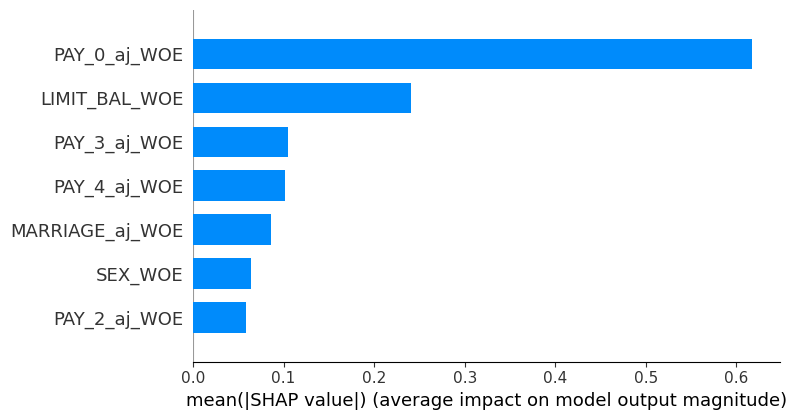

In [72]:
# Crear explainer para modelo lineal
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")

# Obtener valores SHAP para X_test
shap_values = explainer.shap_values(X_test)

# Mostrar gráfico resumen (importancia de características)
shap.summary_plot(shap_values, X_test, plot_type="bar")

Se obtiene una representación visual de la importancia de cada una de las variables del modelo en la predicción de la morosidad. Entre estas, se observa que la más relevante es el comportamiento del cliente en el último mes disponible (PAY_0: Septiembre de 2005), lo que tiene sentido para determinar la morosidad en el siguiente mes.

Otra variable relevante es el LIMIT_BAL, lo que tambien hace sentido, ya que el limite otorgado a cada cliente esta relacionado con su comportamiento y, en consecuencia, con su morosidad (bajos limites estan relacionados con mas morosidades, tal y como se ha analizado en el EDA inicial)

*Nota (Según la documentación del dataset): 

PAY_0 -> estado del pago en sep05

PAY_1 -> estado del pago en aug05

PAY_2 -> estado del pago en jul05

etc

## Analisis individual

Por otro lado, se analiza el detalle de una prediccion especifica, para ver como el modelo estima la probabilidad de impago y la relevancia de cada variable en dicha prediccion. Para ello, se usa una grafica tipo waterfall.

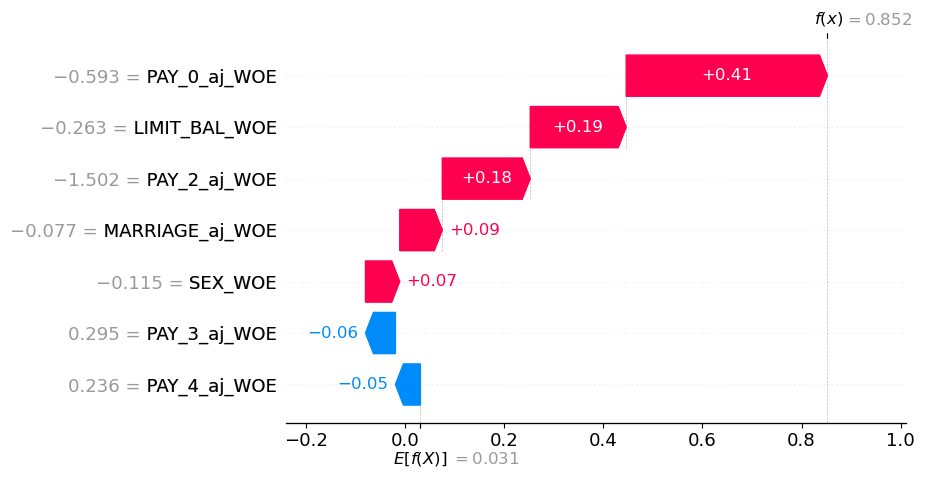

In [ ]:
# Elegir índice de un cliente en el conjunto de test
idx = 0  # puedes cambiar a cualquier otro índice

# Obtener valores SHAP y predicción esperada
shap_values_single = shap_values[idx]
expected_value = explainer.expected_value

# Mostrar gráfico tipo waterfall
shap.plots.waterfall(shap.Explanation(values=shap_values_single,
                                      base_values=expected_value,
                                      data=X_test.iloc[idx],
                                      feature_names=X_test.columns.tolist()))


Tal y como se ha visto inicialmente, las dos variables que más influyen en la prediccion son PAY_0 y LIMIT_BAL, en este caso para aumentar la morosidad. 

Como las variables han entrado al modelo con su valor WOE, la interpretacion no es tan directa, pero para ello se muestra el detalle de los valores originales de las variables en la tabla de debajo, donde se comprueba que el cliente presentaba un mes de atraso en PAY_0 y dos meses en PAY_2 (ambos han contribuido a empeorar su predicción). Por otro lado, como en PAY_3 y PAY_4 no se observan atrasos en los pagos, estos contribuyen a mejorar la estimacion, aunque en menor medida puesto que tienen un menor peso (son mas alejadas en el tiempo, el comportamiento reciente es mas relevante).

Otras variables como SEX (1: Hombre) y MARRIAGE (1: casado) aumentan la probabilidad, ya que estas categorias estan relacionadas con mayor morosidad, tal y como se ha visto en el EDA inicial.

Con todo ello, la predicción de la regresión es correcta, puesto que estima una probabilidad de impago de 85,2% para el mes siguiente y efectivamente la marca de default esta activada (el cliente impagó el mes siguiente).

In [94]:
# Imprimir como tabla
columns_to_print = ['PAY_0_aj', 'PAY_0_aj_WOE', 'PAY_2_aj', 'PAY_2_aj_WOE', 'PAY_3_aj', 'PAY_3_aj_WOE', 'PAY_4_aj', 'PAY_4_aj_WOE', 
                    'SEX', 'SEX_WOE', 'MARRIAGE_aj', 'MARRIAGE_aj_WOE', 'LIMIT_BAL', 'LIMIT_BAL_WOE', target]
df_base.loc[[X_test.index[idx]], columns_to_print]

,PAY_0_aj,PAY_0_aj_WOE,PAY_2_aj,PAY_2_aj_WOE,PAY_3_aj,PAY_3_aj_WOE,PAY_4_aj,PAY_4_aj_WOE,SEX,SEX_WOE,MARRIAGE_aj,MARRIAGE_aj_WOE,LIMIT_BAL,LIMIT_BAL_WOE,default payment next month
16895,1,-0.593072,2,-1.501653,0,0.295164,0,0.235542,1,-0.115154,1,-0.077025,50000,-0.263374,1


# Reflexión y Evaluación Crítica

El modelo de regresión logística desarrollado ha mostrado un desempeño razonable, alcanzando un AUC del 75%, posicionándose entre los mejores resultados obtenidos en la comparativa de modelos. Además, logró un F1-score de 51,8%, una métrica especialmente relevante en este contexto debido al desbalance de clases. Dado que la clase negativa es mayoritaria, métricas como la accuracy (77,6%) pueden resultar engañosas, al reflejar una alta capacidad predictiva solo sobre dicha clase, sin capturar adecuadamente el rendimiento sobre los clientes morosos.

Analizando el comportamiento del modelo frente a los impagos, se observan áreas claras de mejora. La clase positiva (clientes que impagan) representa aproximadamente el 22% de la muestra, y a pesar de haberse aplicado un ajuste por pesos balanceados, el recall (0.54) y la precisión (0.49) se mantienen en niveles moderados. Esto se traduce en un número elevado de falsos negativos (909), es decir, clientes que deberían haber sido rechazados pero fueron clasificados como “buenos”, lo cual representa un riesgo económico directo.

Una primera limitación es, por tanto, el desbalance de clases. Aunque se testó el uso de SMOTE, los resultados no mejoraron significativamente. Por ello, se sugiere explorar métodos alternativos de balanceo como ADASYN, así como la combinación de técnicas de sobremuestreo con selección de variables supervisada.

Otra vía de mejora es el ajuste del umbral de decisión. Actualmente se utiliza el valor por defecto (0.5), pero, dado que el coste asociado a un falso negativo es mayor, podría ser beneficioso desplazar este umbral hacia valores más conservadores, priorizando el recall y disminuyendo el riesgo de impago. Este sería el típico ejercicio a realizar con el cliente para alinear el rendimiento del modelo con las expectativas de negocio.

Asimismo, se recomienda investigar la creación de nuevas variables, por ejemplo, mediante binarizaciones optimizadas según métricas como el AUC o el F1-score.

Por último, si bien modelos como Random Forest o Gradient Boosting no superaron la regresión logística, podrían evaluarse otras alternativas modernas como LightGBM o CatBoost. Estos modelos ofrecen mayor capacidad para capturar interacciones complejas y mantienen la interpretabilidad cuando se combinan con herramientas como SHAP.